XC course ingestion comparison

In [1]:
from math import sqrt, floor

import datetime
from math import sqrt, floor
import numpy as np
import pandas as pd
import haversine

# https://github.com/christopherbronner/gps-run-tracker/blob/master/GPS%20tracker.ipynb
import gpxpy
import gpxpy.gpx
from time import strftime
import matplotlib.pyplot as plt
import copy
from matplotlib.cm import terrain # import color map
from matplotlib.cm import cool # import color map

from geopy import distance as gpyd
from geographiclib.geodesic import Geodesic #for heading
geod = Geodesic.WGS84  # define the WGS84 ellipsoid
import gpx_interpolate #local file

from math import degrees, cos, sin, atan2 #for bearing calculations
from scipy.signal import find_peaks #for hairpin detection

import statistics #for standard deviation of turns
import os #to get files

from scipy.signal import savgol_filter
from scipy import stats # for zscore filtering pace
import seaborn as sns # seaborn for plotting

### Pull in the gps data

In [2]:
def gpxfile_to_lat_lon(path, filename):
    base=os.path.basename(path + filename)
    gpx_file = open(path + filename, 'r')
    gpx = gpxpy.parse(gpx_file)

    lat = []
    lon = []
    ele = []
    tstamp = []
    tzinfo = []

    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                lat.append(point.latitude)
                lon.append(point.longitude)
#                 df_newRow = pd.DataFrame([[point.time, point.latitude, point.longitude, point.elevation]], columns=['time','Lat','Lon','Elevation'])
#                 df = df.append(df_newRow, ignore_index=True)
                ele.append(point.elevation)
    return lat, lon, ele, gpx
#     files.append(filename)
#         courses.append(os.path.splitext(base)[0])

In [3]:
def gpxfile_to_gpx(path, filename):
    base=os.path.basename(path + filename)
    gpx_file = open(path + filename, 'r')
    gpx = gpxpy.parse(gpx_file)
    
    return gpx

In [4]:
def gpx_to_lat_lon(gpx):
    lat = []
    lon = []
    ele = []
    tstamp = []
    tzinfo = []

    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                lat.append(point.latitude)
                lon.append(point.longitude)
#                 df_newRow = pd.DataFrame([[point.time, point.latitude, point.longitude, point.elevation]], columns=['time','Lat','Lon','Elevation'])
#                 df = df.append(df_newRow, ignore_index=True)
                ele.append(point.elevation)
    return lat, lon, ele

In [5]:
# Loads gpx file and returns data frame run
def load_run_to_df(filename): 
    
    # Load file into run_data using gpxpy
    with open(filename) as f:
        run_data = gpxpy.parse(f)
    f.closed
    
    # Initialize DataFrames
    df_dict = {'time': [],'Lat': [],'Lon': [],'Elevation': []}
    df = pd.DataFrame(df_dict)
    
    # Create DataFrame containing time, latitude, longitude, elevation columns
    for track in run_data.tracks:
        for segment in track.segments:
            for point in segment.points:
                df_newRow = pd.DataFrame([[point.time, point.latitude, point.longitude, point.elevation]], columns=['time','Lat','Lon','Elevation'])
                df = df.append(df_newRow, ignore_index=True)
    
    # Convert time to datetime
    df['time'] = pd.to_datetime(df['time'])
    # Create additional column for accumulative distance
    df = add_distance(df)
    
    alt_dif = [0]
    time_dif = [0]
########################################
    #adding alt and time
    data = run_data.tracks[0].segments[0].points
    for index in range(len(data)):
        if index == 0:
            pass
        else:
            start = data[index-1]
            stop = data[index]

            alt_d = start.elevation - stop.elevation
            alt_dif.append(alt_d)

            try:
                time_delta = (stop.time - start.time).total_seconds()
            except:
                #no time in data
                time_delta = 0

            time_dif.append(time_delta)

    df1 = pd.DataFrame()
    df1['alt_dif'] = alt_dif
    df1['time_dif'] = time_dif

    print('Total Time : ', floor(sum(time_dif)/60),' min ', int(sum(time_dif)%60),' sec ')
    df = pd.concat([df, df1], axis=1)
########################################

    return df

# path_bayfront = '/Users/jeremywalsh/Documents/Projects/XC/XCCourseAnalysis/Courses/Bayfront Park 7km.gpx'
# df = load_run_to_df(path_bayfront)
# df.head()

# # Calculate total distance of this run
# total_distance = df.iloc[-1]['Distance']    
# print('Total distance: \t%.2f km' % total_distance)

## Get the heading

In [6]:
def angle_diff(df, window):
    bearing = []
    p2p_distance = []

    for i in range(len(df['Lon'])-1):
        lon1 = df['Lon'].values[i]
        lat1 = df['Lat'].values[i]
        lon2 = df['Lon'].values[i+1]
        lat2 = df['Lat'].values[i+1]

        bearing_tmp = atan2(sin(lon2-lon1)*cos(lat2), cos(lat1)*sin(lat2)-sin(lat1)*cos(lat2)*cos(lon2-lon1))
        bearing_tmp = degrees(bearing_tmp)
        bearing_tmp = (bearing_tmp + 360) % 360
        bearing.append(bearing_tmp)

    #     bearing.append(Geodesic.WGS84.Inverse(lon1, lat1, lon2, lat2)['azi1']) #degrees clockwise from north)
        p2p_distance.append(Geodesic.WGS84.Inverse(lon1, lat1, lon2, lat2)['s12']) #distance between each point in meters
    
    #smoothing the bearing since for some tracks it is messy and throws off hairpin detection
#     bearing = savgol_filter(bearing, 41, 2) # window size 51, polynomial order 2
    
    # bearing.insert(0, np.nan) #making the same length as df
    p2p_distance.insert(0, 0) #making the same length as df
    p2p_distance = np.cumsum(p2p_distance)


    bearing_diff = [bearing[i + 1] - bearing[i] for i in range(len(bearing)-1)]
    angle_diff = [(bearing_diff[i] + 180) % 360 - 180 for i in range(len(bearing)-1)]

    angle_df = pd.DataFrame(angle_diff).rolling(window=window, center=True).sum()
    angle_df = angle_df.abs() # taking the absolute value so we get all the peask

    angle_df.loc[-1] = [np.nan]
    angle_df.loc[-2] = [np.nan]

    angle_df.index = angle_df.index + 3  # shifting index
    angle_df.sort_index(inplace=True) 

    df['angle_diff'] = angle_df[0]
    return df, bearing

## Hairpin turn detection via bearing angle difference peak detection

In [7]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show
output_notebook()

Loading BokehJS ...

In [8]:
def hairpin_detection(df, height, bearing, course):
    peaks, _ = find_peaks(df['angle_diff'], height=height, prominence=50)
    print('Number of hairpins in course')
    print(len(peaks))
    
#     plot it
    fig = plt.figure(figsize=(20,8))
    plt.plot(df['angle_diff'])
    plt.plot(bearing)
    
    plt.scatter(peaks, df['angle_diff'].iloc[peaks])
    plt.title('Bearing and Bearing Changes - ' + str(course))
    plt.show()
    
    # bokeh
    # Create the figure: p
    p = figure(title='Course Map with Hairpins - ' + str(course), x_axis_label='Lon', y_axis_label='Lat', plot_width=500, plot_height=500)
    # Add a circle glyph to the figure p
    p.circle(df['Lon'], df['Lat'], size = 0.5)
    p.circle(df['Lon'].iloc[peaks], df['Lat'].iloc[peaks], color='red', size = 10, alpha=0.8)
    # Display the plot
    show(p)
    
    
    print('Standard Deviation')
    st_dev = statistics.stdev(df['angle_diff'].dropna())
    print(st_dev)
    print('Total Degrees Turned')
    tot_deg_turned = sum([abs(ele) for ele in df['angle_diff'].dropna()])
    print(tot_deg_turned)
    
    return st_dev, tot_deg_turned, len(peaks)

In [9]:
from scipy.signal import argrelextrema

def plot_ele_max_min(df):
    # Plot results
    fig = plt.figure(figsize=(20,8))
    plt.scatter(df['dis_hav_3d'], df['min'], c='r')
    plt.scatter(df['dis_hav_3d'], df['max'], c='g')
    plt.plot(df['dis_hav_3d'], df['Elevation'])
    plt.show()

## Calculate Course Area
Look at the total area the course covers as a comparison for how turny the course is. ie how good is the course/race director at minimizing turns (if that was a desired goal).

In [10]:
def course_area(geod, df):
    p = geod.Polygon()
    for pnt in range(len(df)):
        if pnt == 0:
            continue
        p.AddPoint(df['Lat'][pnt], df['Lon'][pnt])

    num, perim, area = p.Compute()
    print("Race Distance/area of the course are {:.3f} m / {:.1f} m^2".format(perim, area))
    return perim, area

In [11]:
def hills(df):
    n=20 # number of points to be checked before and after 
    # Find local peaks
    df['min'] = df.iloc[argrelextrema(df['Elevation'].values, np.less_equal, order=n)[0]]['Elevation']
    df['max'] = df.iloc[argrelextrema(df['Elevation'].values, np.greater_equal, order=n)[0]]['Elevation']

    max_locs = df['max'].index.get_indexer(df['max'].index[~df['max'].isnull()]) #index locations of the max's
    min_locs = df['min'].index.get_indexer(df['min'].index[~df['min'].isnull()]) #index locations of the min's

    #min locs remove duplicates
    for i in range(len(min_locs)):
        if i == len(min_locs)-1: #skip the last one
            continue
        else:
            if min_locs[i] == min_locs[i+1]-1: #check if it is the same as the previous one
                df['min'][min_locs[i]] = np.nan #setting it to nan so we don't have duplicates

    min_locs = df['min'].index.get_indexer(df['min'].index[~df['min'].isnull()])

    #max locs remove duplicates
    for i in range(len(max_locs)):
        if i == len(max_locs)-1: #skip the last one
            continue
        else:
            if max_locs[i] == max_locs[i+1]-1: #check if it is the same as the previous one
                df['max'][max_locs[i]] = np.nan #setting it to nan so we don't have duplicates

    max_locs = df['max'].index.get_indexer(df['max'].index[~df['max'].isnull()])
    
    # get the hill climbs
    min_vals = []
    max_vals = []
    hill_climbs = []
    hill_lengths = []

    for i in range(len(max_locs)): #loop through each max location
        if i == len(max_locs)-1: #skip the last one to avoid out of range error b/c zero index
            continue
        else:
            min_val = df['min'][min_locs[i]] #get this hill's min elevation
            max_val = df['max'][max_locs[i]] #get this hill's max elevation
            hill_climb = max_val - min_val #get the hill climb amount

            hill_start = df['dis_hav_3d'][min_locs[i]] #get this hill's start point
            hill_end = df['dis_hav_3d'][max_locs[i]] #get this hill's end point
            hill_length = hill_end - hill_start

            min_vals.append(min_val)
            max_vals.append(max_val)
            hill_climbs.append(hill_climb)
            hill_lengths.append(hill_length)
            
    plot_ele_max_min(df)
        
    return min_vals, max_vals, hill_climbs, hill_lengths, df

In [12]:
def hill_details(df, peaks, mins):
    #if the first point is a peak then set the start as the min
    if len(peaks)>0 and peaks[0]<mins[0]:
        mins = np.insert(mins, 0, 0)
        
    
    # get the hill climbs
    min_vals = []
    max_vals = []
    hill_climbs = []
    hill_lengths = []

    for i in range(len(peaks)): #loop through each max location
        try: #error handling for weird numbered hills
            min_val = df['Elevation'].iloc[mins[i]] #get this hill's min elevation
            max_val = df['Elevation'].iloc[peaks[i]] #get this hill's max elevation
            hill_climb = max_val - min_val #get the hill climb amount

            hill_start = df.index[mins[i]] #get this hill's start point
            hill_end = df.index[peaks[i]] #get this hill's end point
            hill_length = hill_end - hill_start

            min_vals.append(min_val)
            max_vals.append(max_val)
            hill_climbs.append(hill_climb)
            hill_lengths.append(hill_length)
        except:
            print('one hill error')
        
    return min_vals, max_vals, hill_climbs, hill_lengths

In [13]:
def positive_only(x):
    if x > 0:
        return x
    else:
        return 0
    
def myround(x, prec=1, base=0.5):
    return round(base * round(float(x)/base),prec)

In [14]:
def hills_peaks(df, prominence, distance, course):
    peaks, _ = find_peaks(df['Elevation'], prominence=prominence, distance=distance)
    mins, _ = find_peaks(-df['Elevation'], prominence=prominence, distance=distance)

#     plot it
    fig = plt.figure(figsize=(20,8))
#     plt.rcParams.update({'font.size': 22})
    plt.plot(df['Elevation'])
    plt.scatter(df.index[peaks], df['Elevation'].iloc[peaks], color='red')
    plt.scatter(df.index[mins], df['Elevation'].iloc[mins], color='blue')
    plt.title('Elevation and Peaks - ' + str(course))
    plt.show()
    
    #plot them on the course
    # bokeh
    p = figure(title='Course Map with Hill Peaks - ' + str(course), x_axis_label='Lon', y_axis_label='Lat', plot_width=500, plot_height=500)
    # Add a circle glyph to the figure p
    p.circle(df['Lon'], df['Lat'], size = 0.5)
    p.circle(df['Lon'].iloc[peaks], df['Lat'].iloc[peaks], color='red', size = 10, alpha=0.8)
    p.circle(df['Lon'].iloc[mins], df['Lat'].iloc[mins], color='blue', size = 10, alpha=0.8)
    # Display the plot
    show(p)
    
    st_dev = statistics.stdev(df['Elevation'].dropna())
    
    pos_only = list(map(positive_only, df['alt_dif']))
    tot_elev_gain = sum(list(map(lambda x: myround(x, prec=1, base=0.9) , pos_only)))
    tot_elev_gain_unfiltered = sum(pos_only)
    
    return st_dev, peaks, mins, tot_elev_gain, tot_elev_gain_unfiltered

In [15]:
def add_distance(df):
    tmp = [0]
#     for i, row in df[1:].iterrows():
    for i, item in enumerate(df.index):
        prevCoord = (df.iloc[i-1]['Lat'],df.iloc[i-1]['Lon'])
        currCoord = (df.iloc[i]['Lat'],df.iloc[i]['Lon'])
        tmp.append(tmp[-1] + gpyd.geodesic(prevCoord, currCoord).km)
    df['Distance']=tmp[1:]
    return df

# Need to fix pace, right now it's zeros

In [34]:
# Calculate current pace
def add_pace(df):

    #drop when distance change is zero for unknown reasons
    df = df[df['DistanceChangeInKM']!=0] 
    
    pace_hist = ((df['time_dif']/60)/df['DistanceChangeInKM']).values
    df['PaceInMinPerKM'] = pace_hist

    # remove spikes (if a value is more than spike_tolerace times larger than the mean of the surrounding values)
    spike_tolerance = 1.3
    pace_hist_nospikes = copy.copy(pace_hist)
    for i in range(len(pace_hist_nospikes)):
        if i>1 and i<(len(pace_hist_nospikes)-2):
            if pace_hist_nospikes[i] > spike_tolerance * np.mean([pace_hist_nospikes[i-2],pace_hist_nospikes[i-1],pace_hist_nospikes[i+1],pace_hist_nospikes[i+2]]):
                pace_hist_nospikes[i] = np.mean([pace_hist_nospikes[i-2],pace_hist_nospikes[i+2]])


    # running average of pace (without spikes), N is width of average    
    N = 23 # N must be 2n+1
    pace_hist_binned = np.convolve(pace_hist_nospikes, np.ones((N,))/N, mode='valid')
    
    # Add Pace
    df['pace']=np.nan
    df['pace'].iloc[int((N-1)/2):-int((N-1)/2)]=pace_hist_binned
    
    print(len(df))
    print(len(df.dropna()))
    print(len(df['pace'].dropna()))
    
    #drop outlier in pace (sometimes watch seems to be stopped early or late)
    df = df.dropna()[(np.abs(stats.zscore(df.dropna()['pace'])) < 3)]
    
    # Plot original pace trace in grey and spike-removed, averaged trace in red
    fig = plt.figure(figsize=(20, 8))
    #plt.plot(df['accuDist'][1:],pace_hist,'#dddddd')
#     plt.plot(df['accuDist'][1+int((N-1)/2):-int((N-1)/2)],pace_hist_binned,'r') #rolling average plot
#     plt.plot(df['accuDist'][1:],[avg_pace/60 for i in range(len(df['accuDist'][1:]))],'b') #average line
    plt.plot(df.index,df['pace'],'r') #rolling average plot
    plt.title('Pace')
    plt.ylabel('pace (min per km)')
    plt.xlabel('distance (km)')
    plt.show()
    
    return df

In [17]:
def elev_map(course, df):
    fig = plt.figure(figsize=(10, 10))
    plt.title(course + ' - Elevation')
    plt.scatter(x=df['Lat'], y=df['Lon'], c=df['Elevation'], cmap=plt.cm.inferno)
    plt.ylabel('Lon')
    plt.xlabel('Lat')
    buffer = 0.0001
    plt.xlim(df['Lat'].min()-buffer, df['Lat'].max()+buffer)
    plt.ylim(df['Lon'].min()-buffer, df['Lon'].max()+buffer)

    cbar = plt.colorbar()
    cbar.set_label('Elevation (m)')

    plt.show()

In [18]:
def pace_elev_map(course, df):
    fig = plt.figure(figsize=(10, 10))
    plt.title(course + ' - Elevation and Pace')
    # sc = plt.scatter(x=df['Lat'], y=df['Lon'], c=df['pace'], cmap=plt.cm.inferno, s = scaler.transform(df[['Elevation']])*50)
    h_min = df['Elevation'].min()
    h_const = 10 #constant to adjust the heights
    f = lambda a: a-h_min+h_const 
    g = lambda s: s+h_min-h_const
    sc = plt.scatter(x=df['Lat'], y=df['Lon'], c=df['pace'], cmap=plt.cm.inferno, s = f(df[['Elevation']].values))
    # sc = plt.scatter(x=df['Lat'], y=df['Lon'], c=df['pace'], cmap=plt.cm.inferno, s = df['Elevation'])
    plt.ylabel('Lon')
    plt.xlabel('Lat')
    buffer = 0.0001
    plt.xlim(df['Lat'].min()-buffer, df['Lat'].max()+buffer)
    plt.ylim(df['Lon'].min()-buffer, df['Lon'].max()+buffer)
    cbar = plt.colorbar()
    cbar.set_label('Pace (min)')

    plt.legend(*sc.legend_elements("sizes", num=5, func=g), title='Elevation (m)')

    plt.show()

King City 10km.gpx
Total Time :  33  min  12  sec 
Number of hairpins in course
9


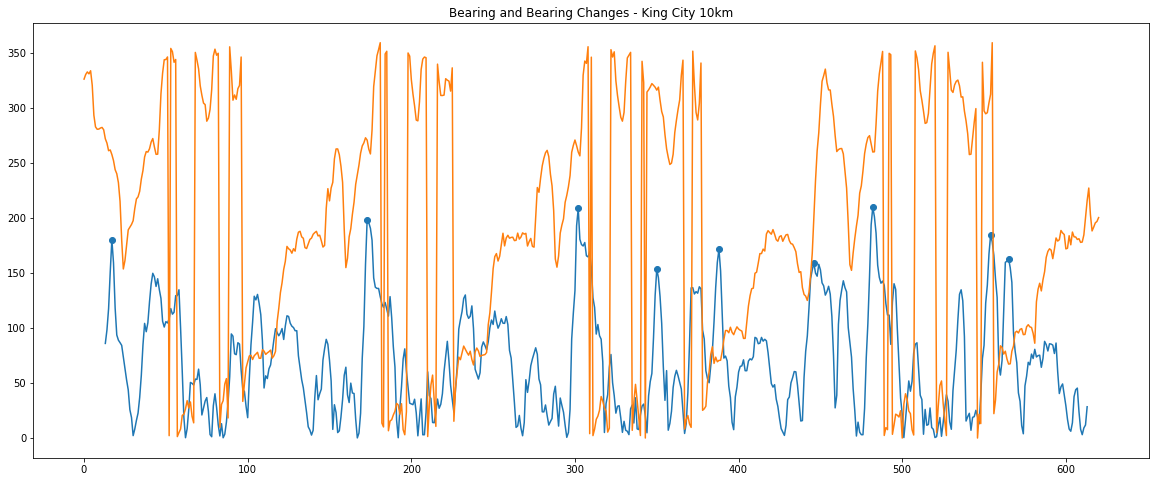

Standard Deviation
48.73036472888027
Total Degrees Turned
42051.013427267426
Race Distance/area of the course are 10038.908 m / -950170.4 m^2
620
596
597


/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

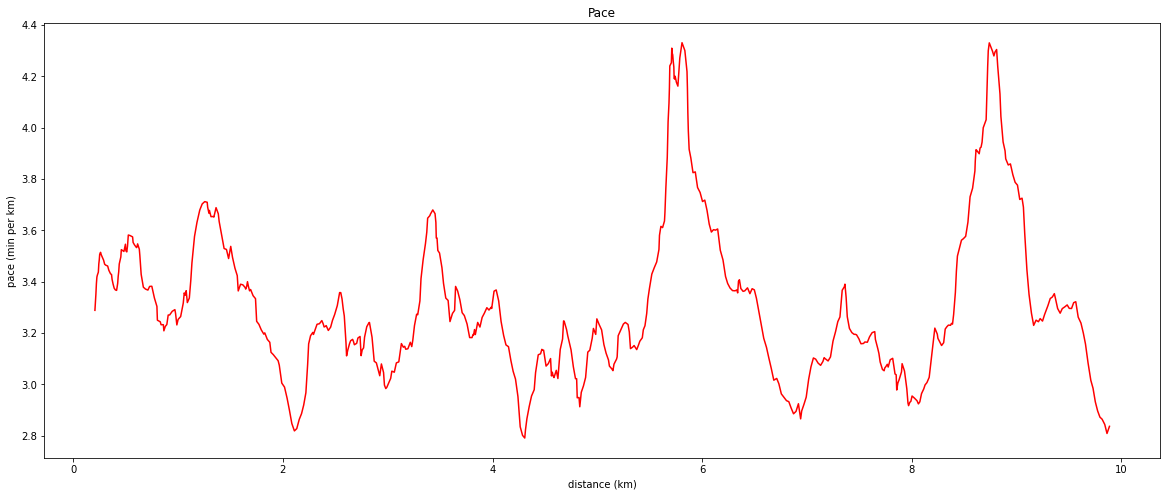

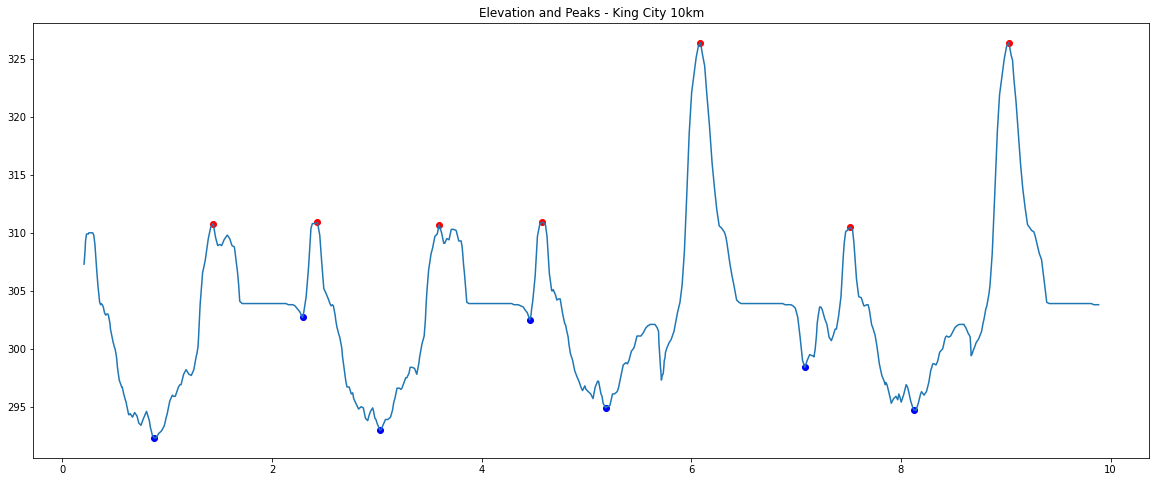

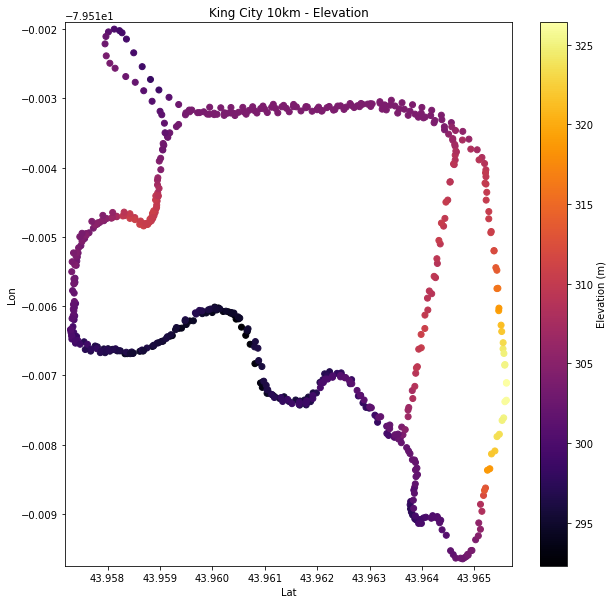

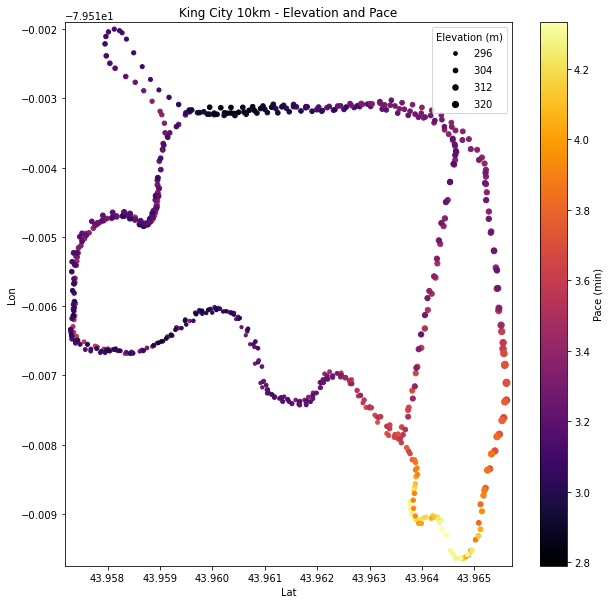

Course average grade adjusted pace - Strava, Minetti
1.0164696929996315 1.0129389606227428
Western International 10km.gpx
Total Time :  33  min  53  sec 
Number of hairpins in course
18


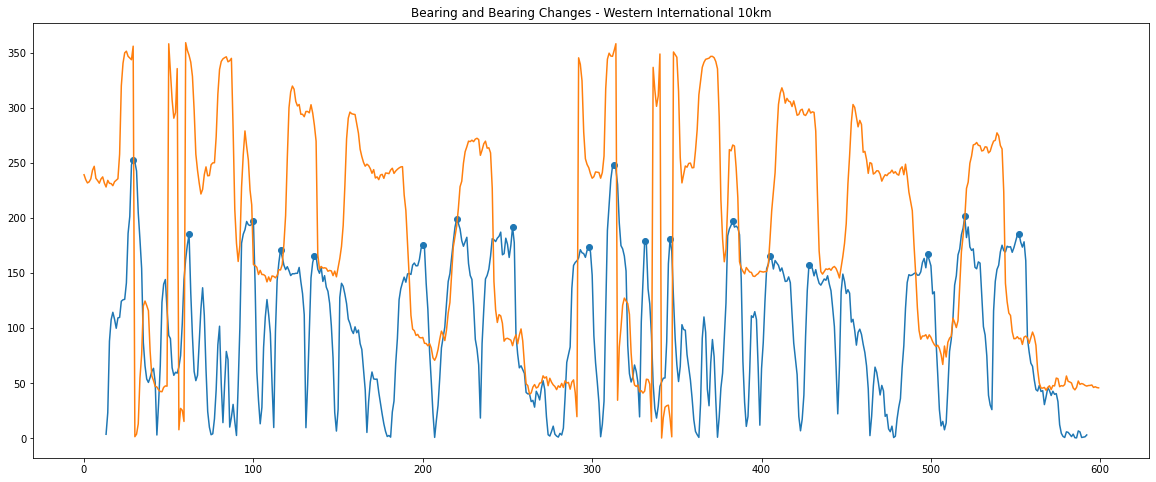

Standard Deviation
62.71863539395597
Total Degrees Turned
58241.752842641436
Race Distance/area of the course are 9968.833 m / 460036.2 m^2
601
577
578


/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


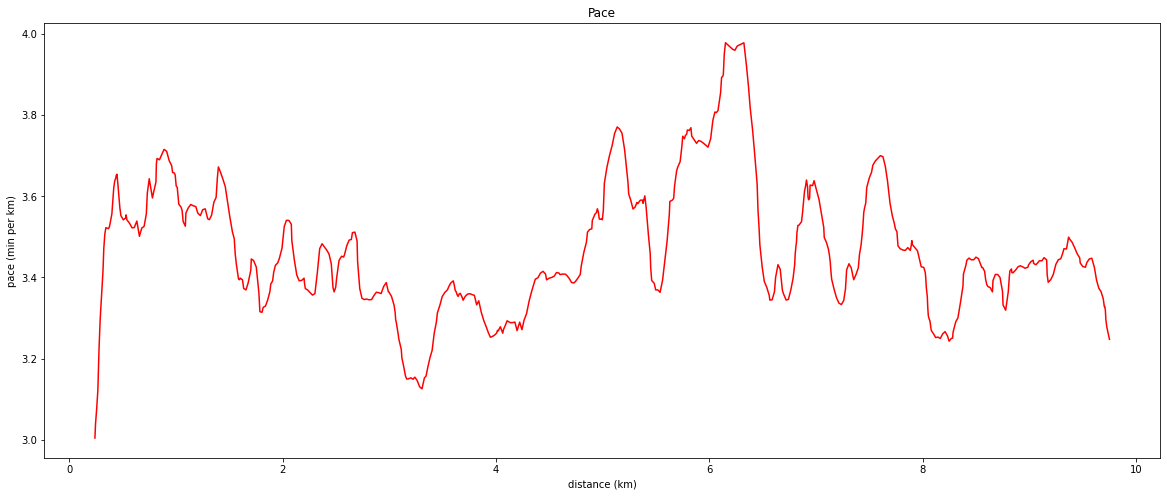

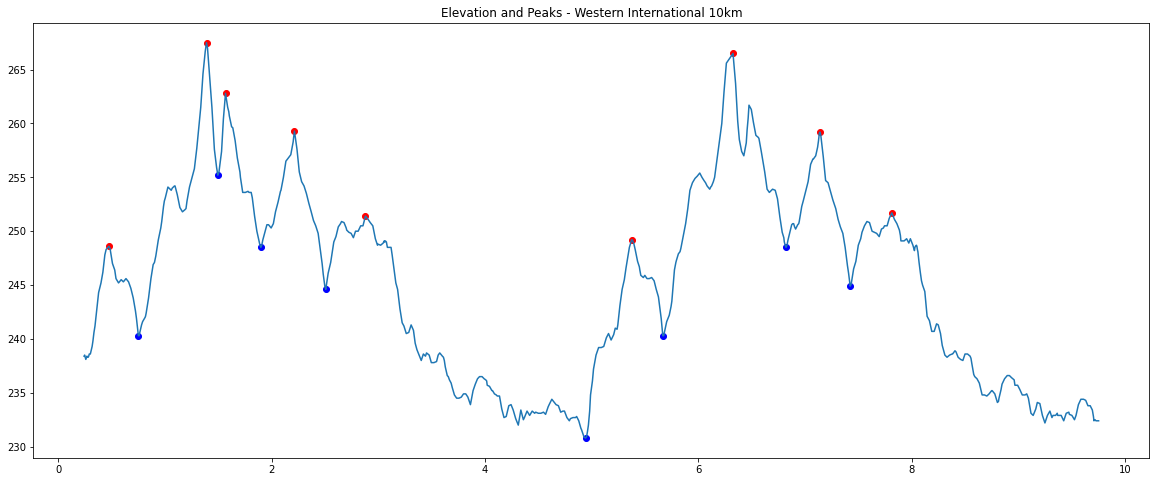

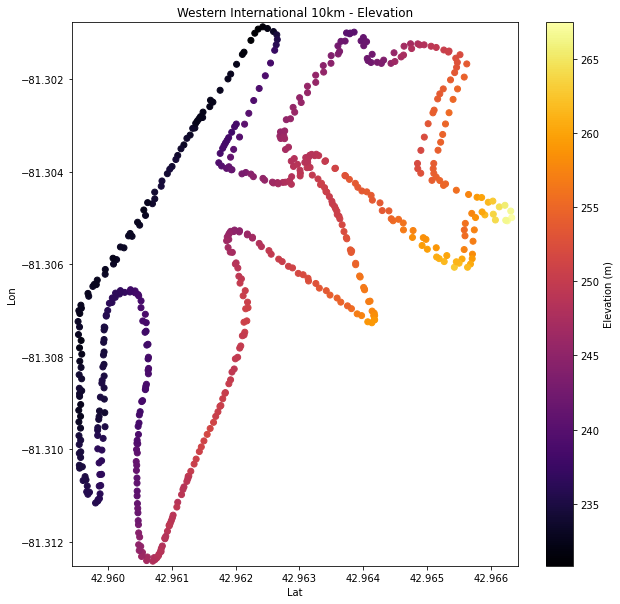

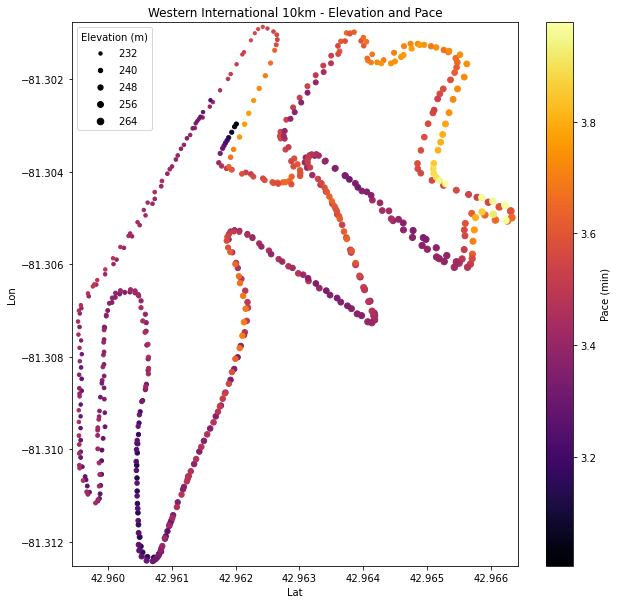

Course average grade adjusted pace - Strava, Minetti
1.0106185037345208 1.0147744314674891
Louisville Classic 8km.gpx
Total Time :  26  min  10  sec 
Number of hairpins in course
5


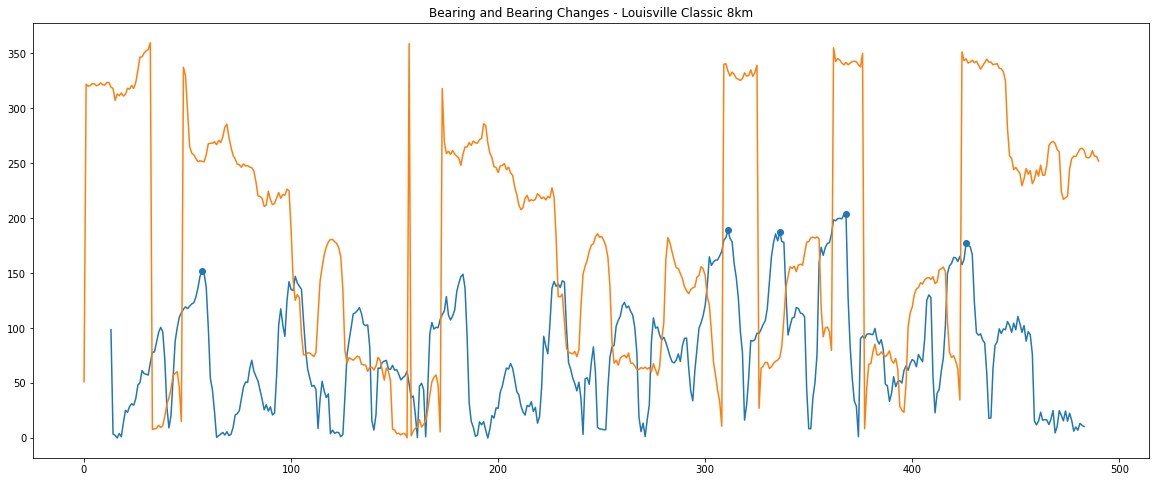

Standard Deviation
51.23413461482195
Total Degrees Turned
36288.40982226491
Race Distance/area of the course are 8540.026 m / 643863.7 m^2
492
468
469


/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


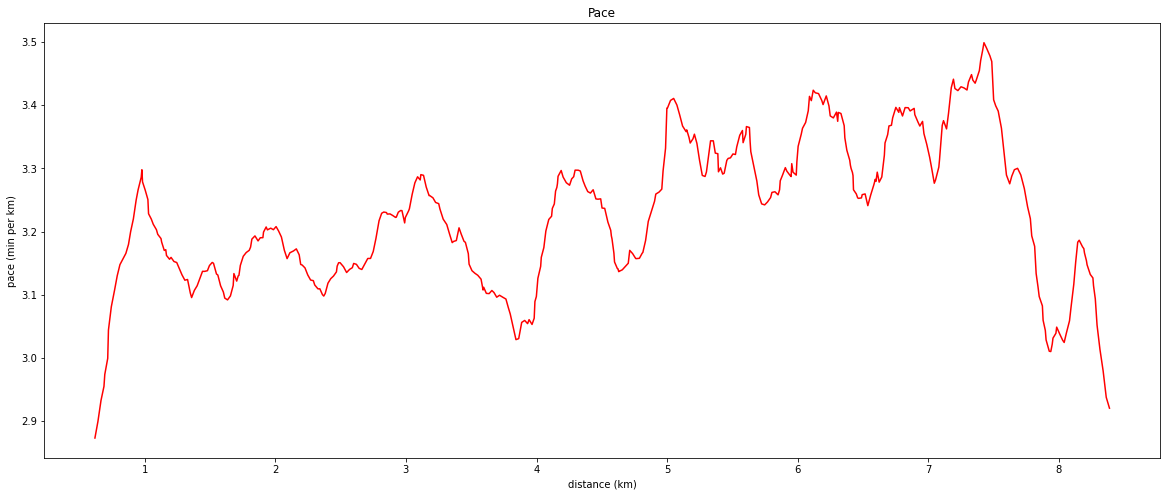

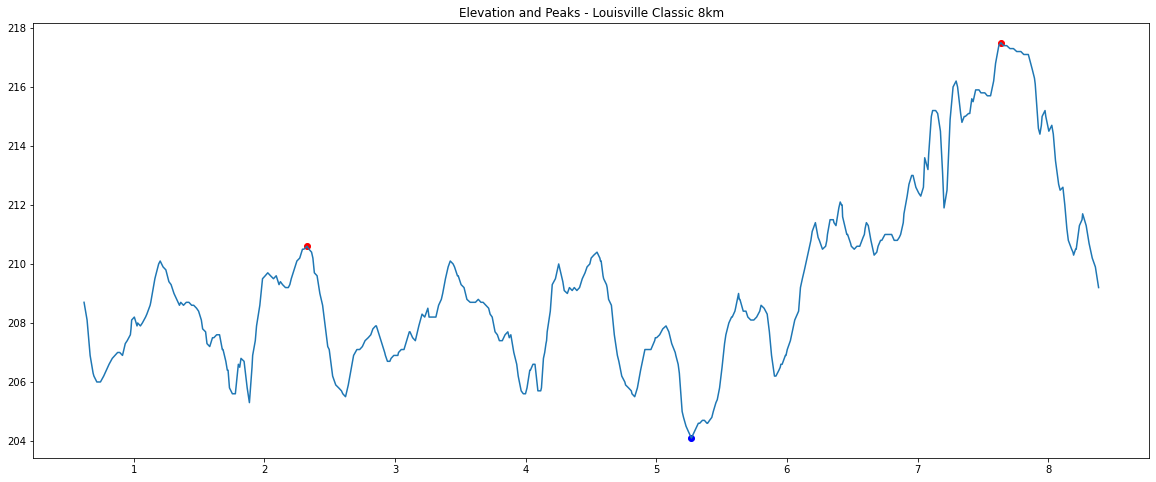

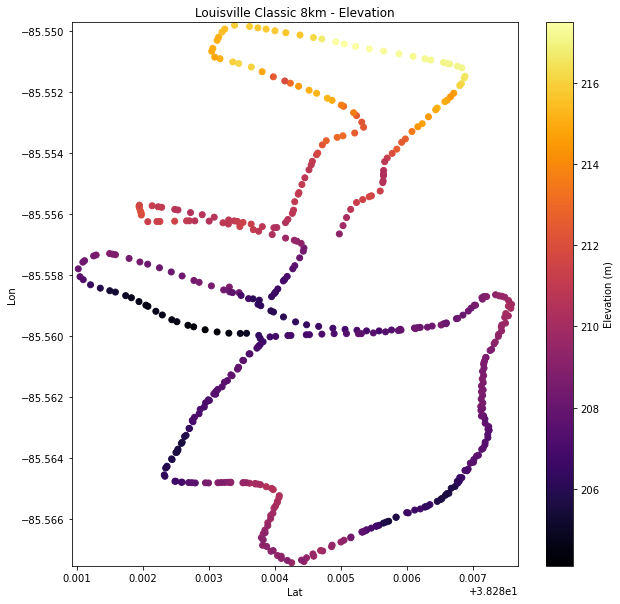

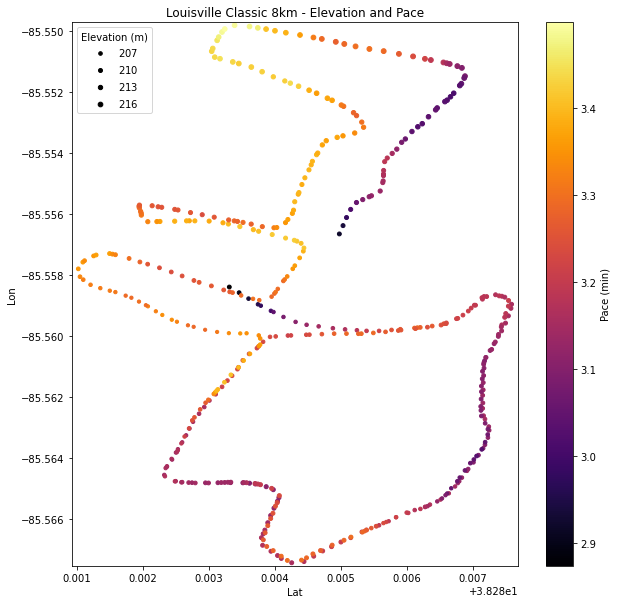

Course average grade adjusted pace - Strava, Minetti
0.9983824117630634 1.006806337249526
Fort Henry 10km.gpx
Total Time :  35  min  33  sec 
Number of hairpins in course
21


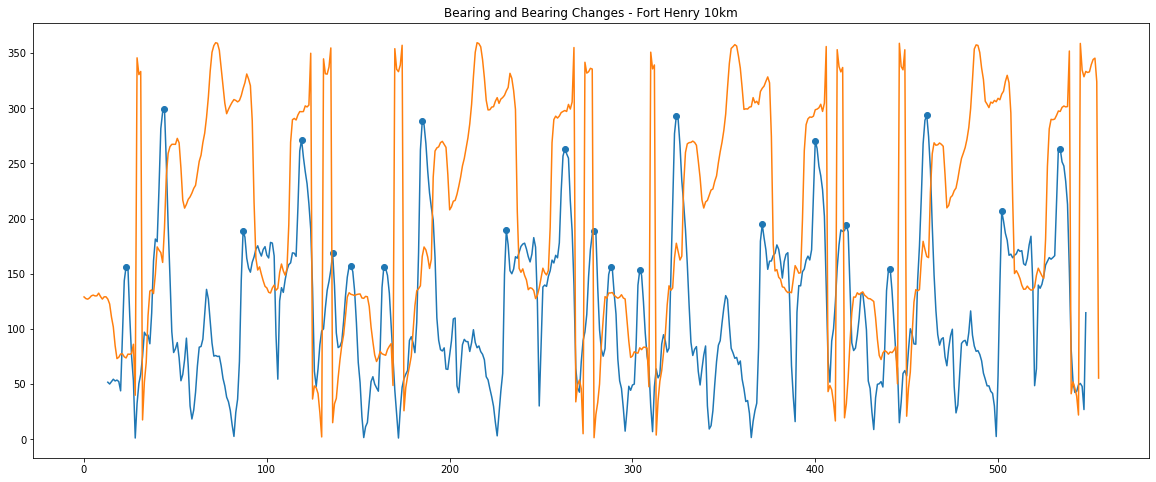

Standard Deviation
66.86682046023945
Total Degrees Turned
62355.74663491335
Race Distance/area of the course are 10110.727 m / -324374.4 m^2
557
533
534


/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


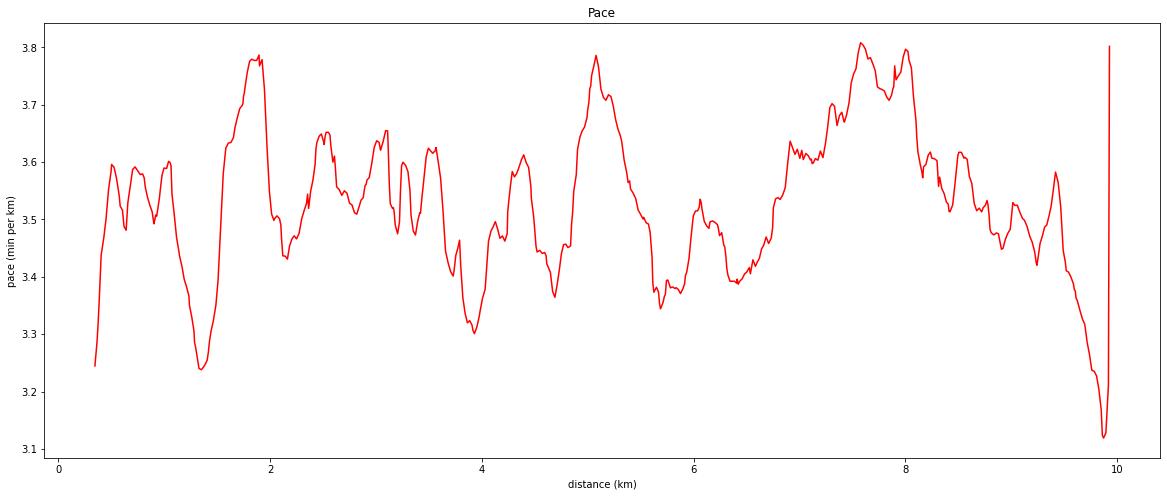

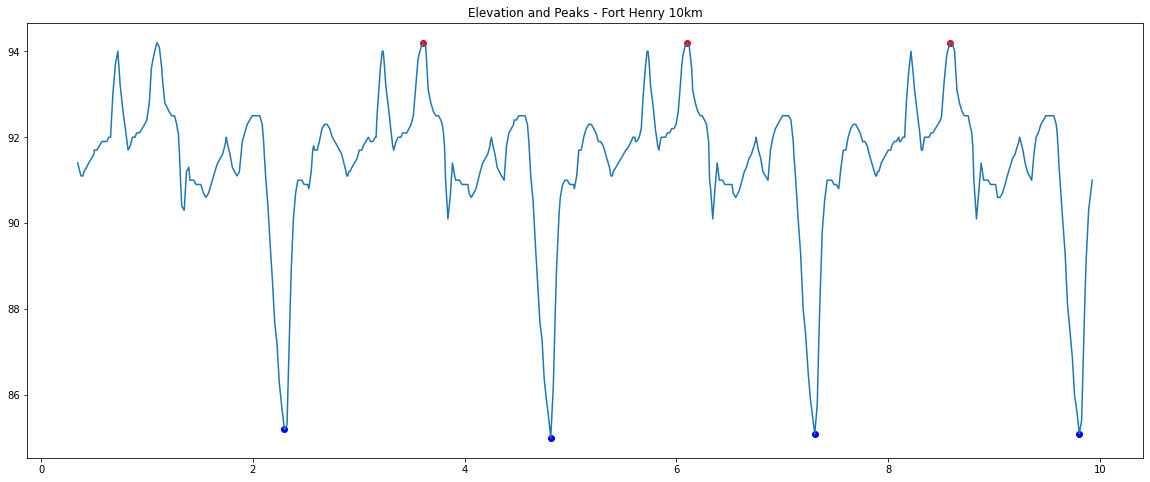

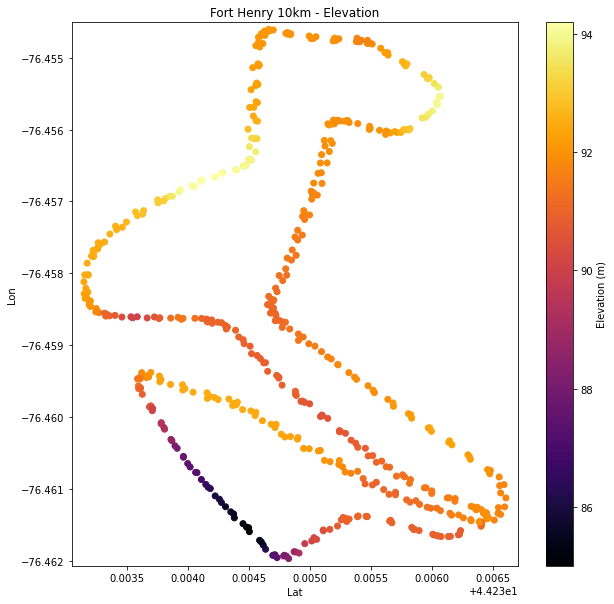

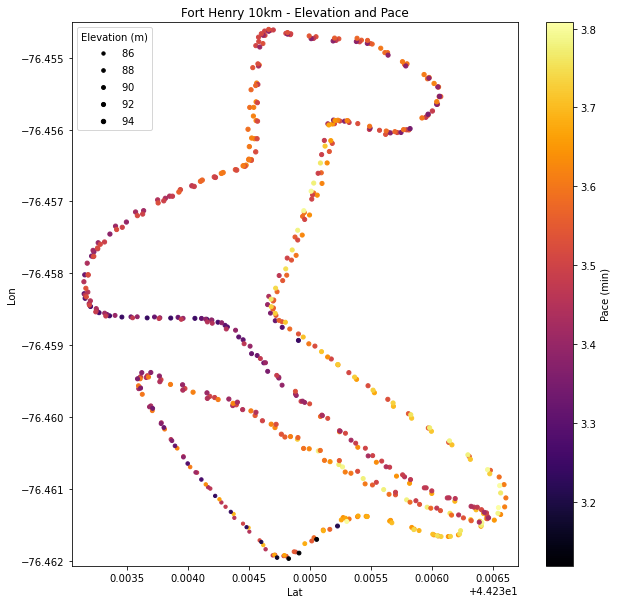

Course average grade adjusted pace - Strava, Minetti
0.9955420361092105 1.0010440699377015
Point Pleasant Park.gpx
Total Time :  34  min  14  sec 
Number of hairpins in course
26


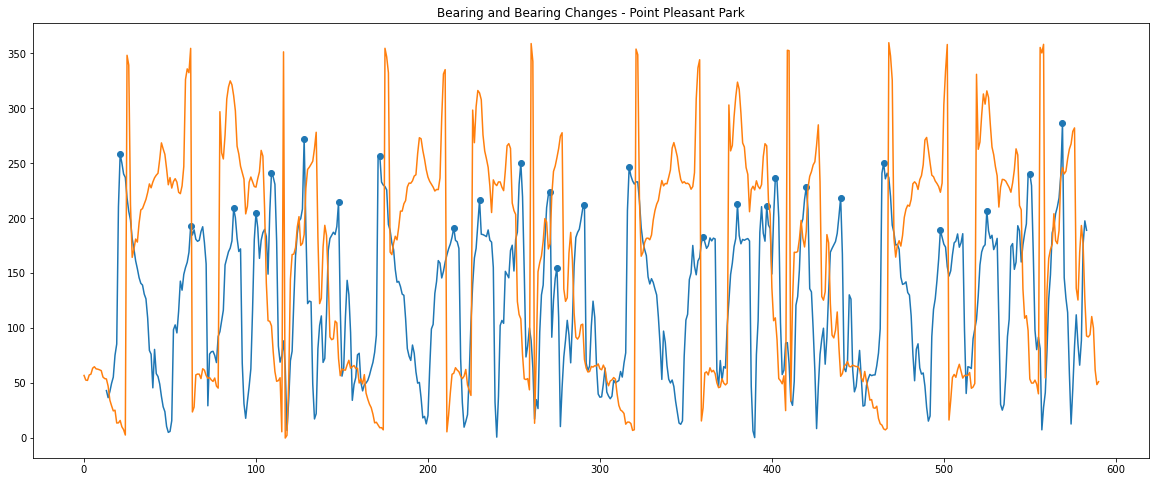

Standard Deviation
65.56650868081097
Total Degrees Turned
71603.02462827564
Race Distance/area of the course are 9724.775 m / 228902.2 m^2
592
568
569


/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


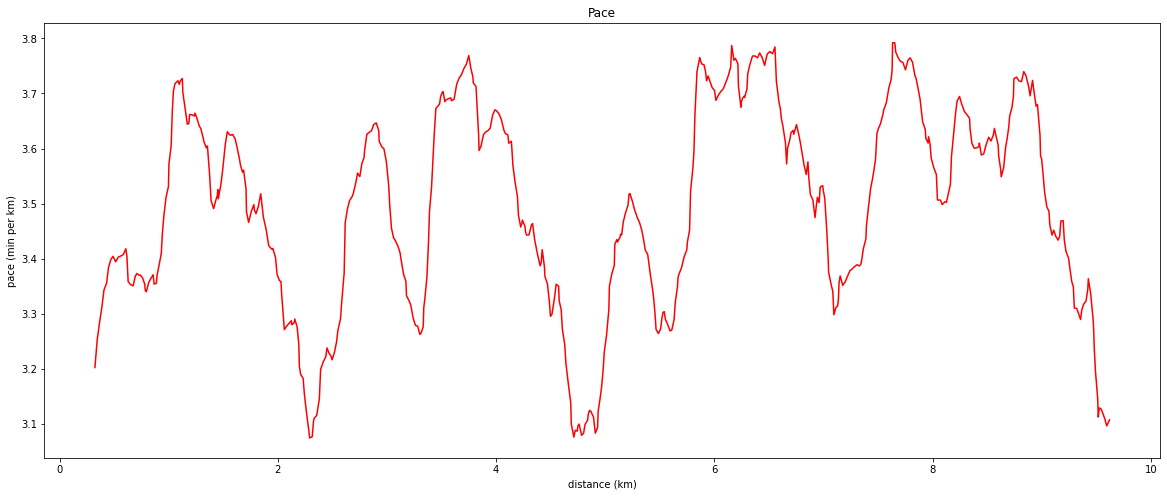

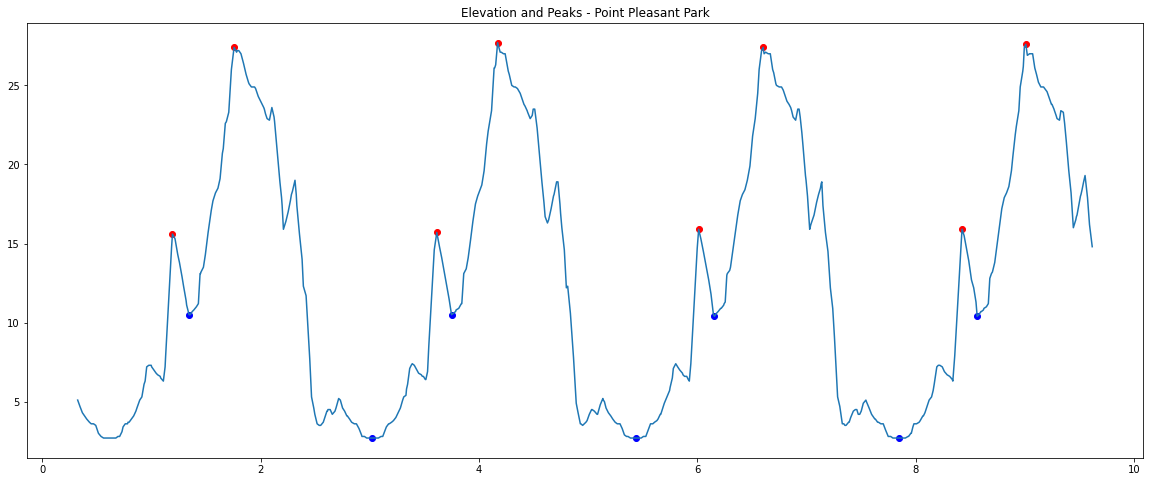

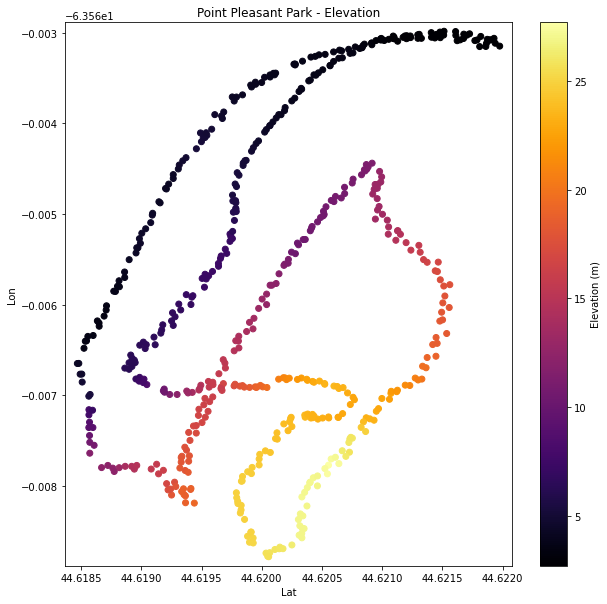

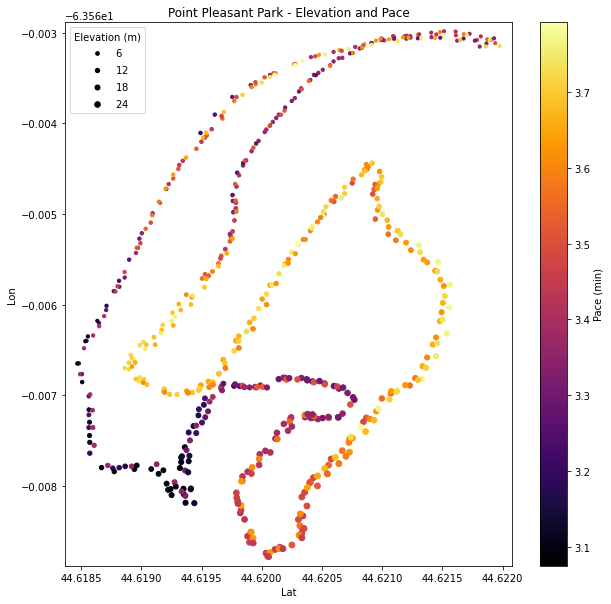

Course average grade adjusted pace - Strava, Minetti
1.014212733749613 1.018651641046345
Malden Park 10km.gpx
Total Time :  32  min  43  sec 
Number of hairpins in course
20


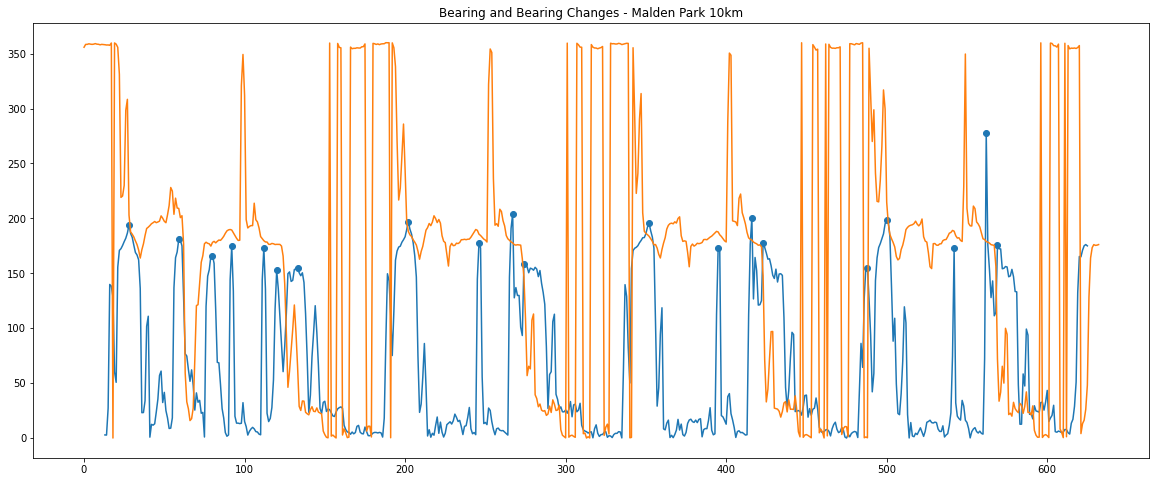

Standard Deviation
66.5491885819257
Total Degrees Turned
39089.09853600058
Race Distance/area of the course are 9634.530 m / -651923.8 m^2
634
610
611


/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


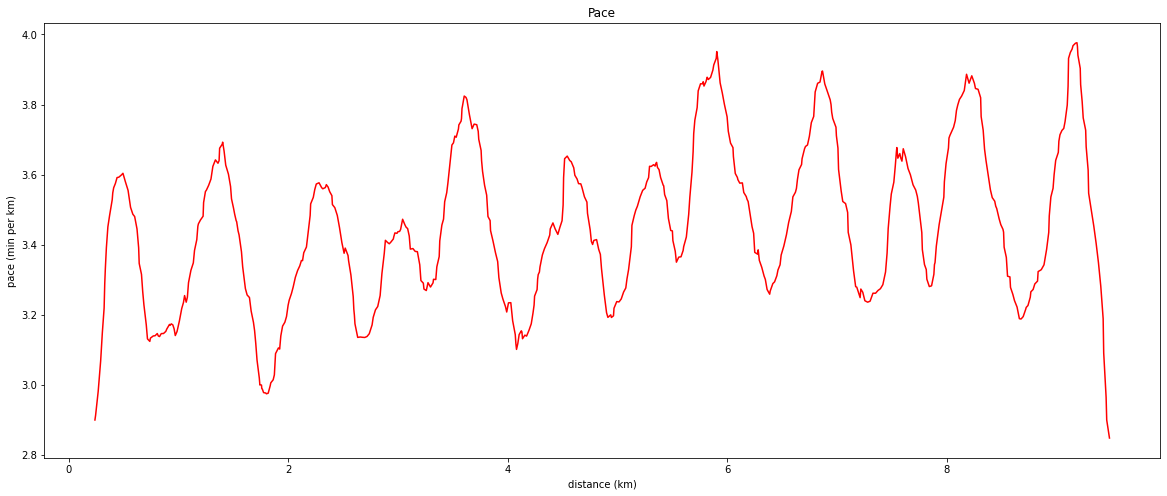

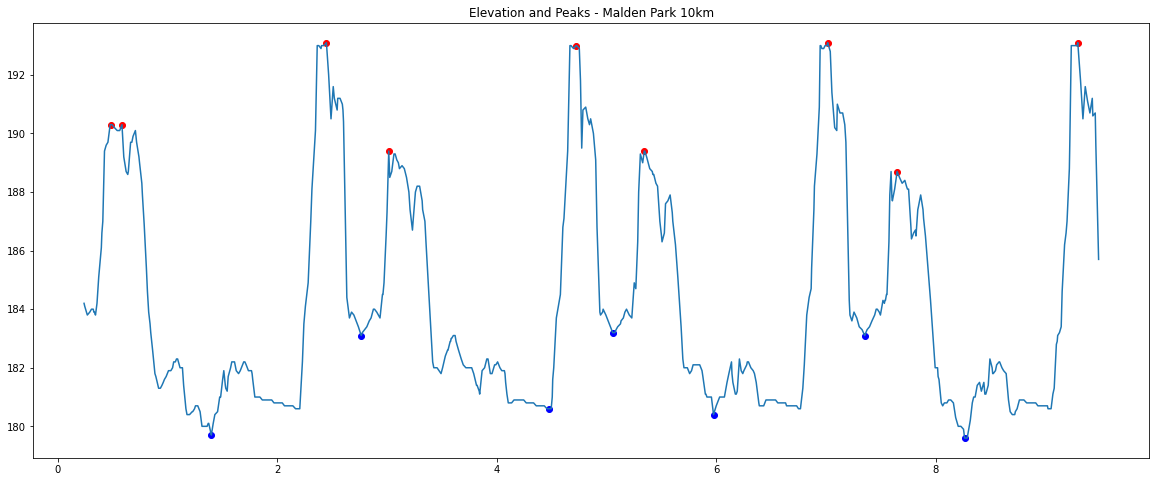

one hill error


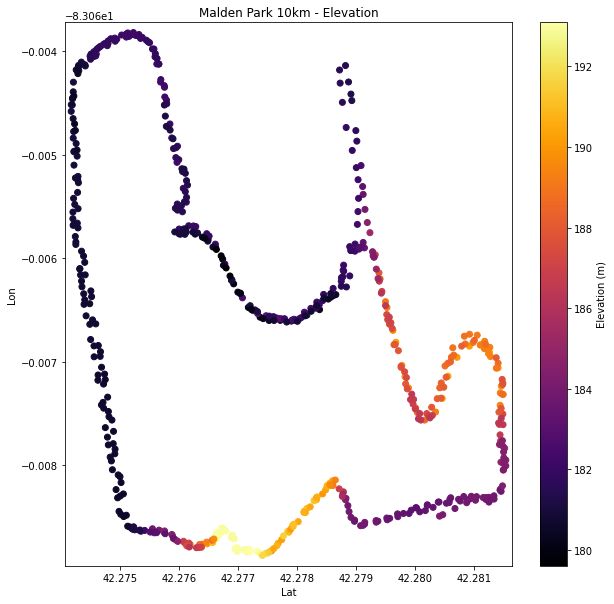

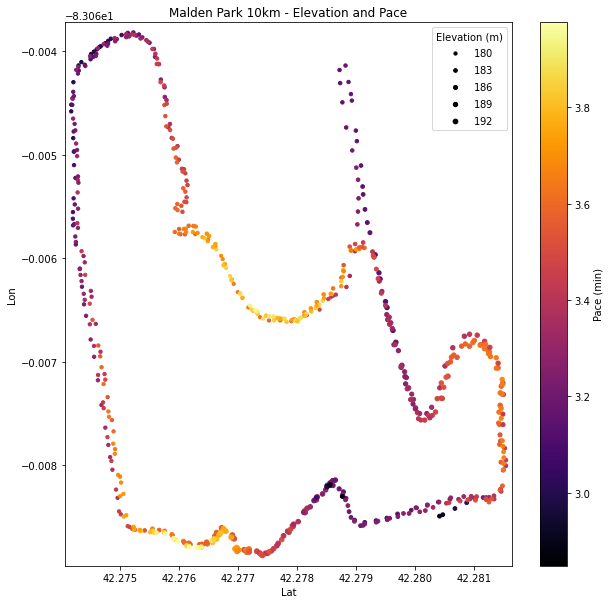

Course average grade adjusted pace - Strava, Minetti
1.0097398244959037 1.0148696437789335
Moncton Classic 8km.gpx
Total Time :  29  min  58  sec 
Number of hairpins in course
12


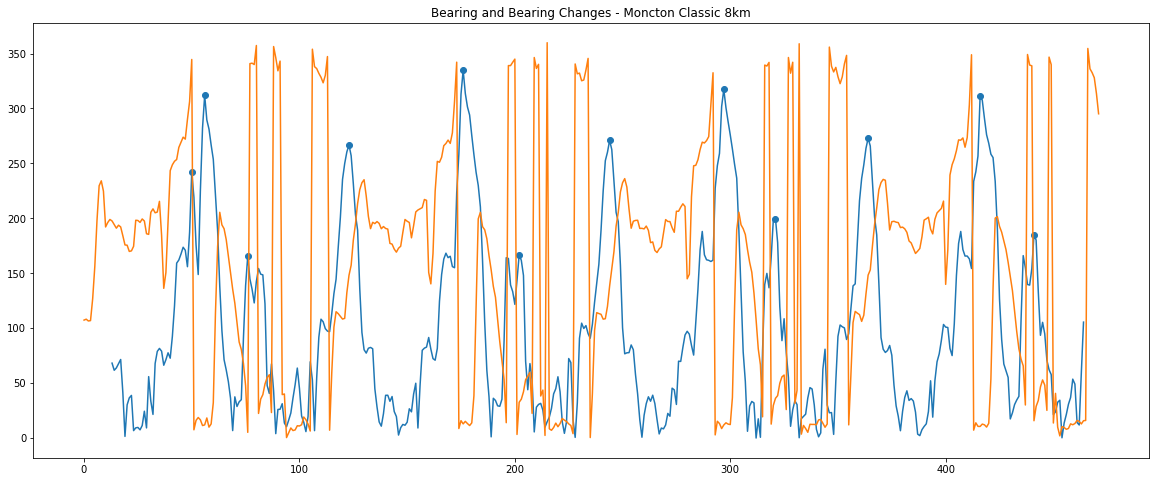

Standard Deviation
83.69674134340447
Total Degrees Turned
45938.70374706484
Race Distance/area of the course are 8300.696 m / 112459.9 m^2
473
449
450


/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


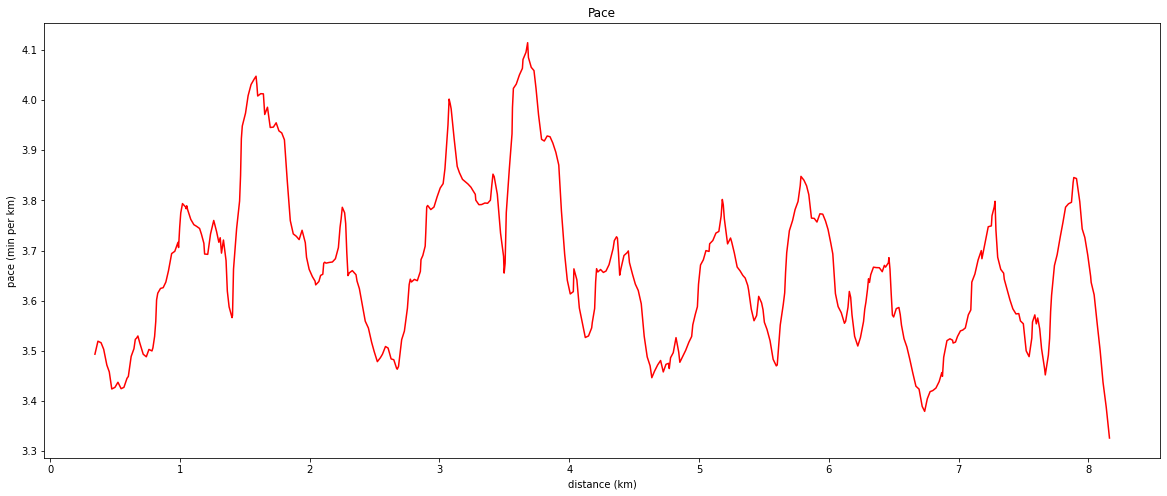

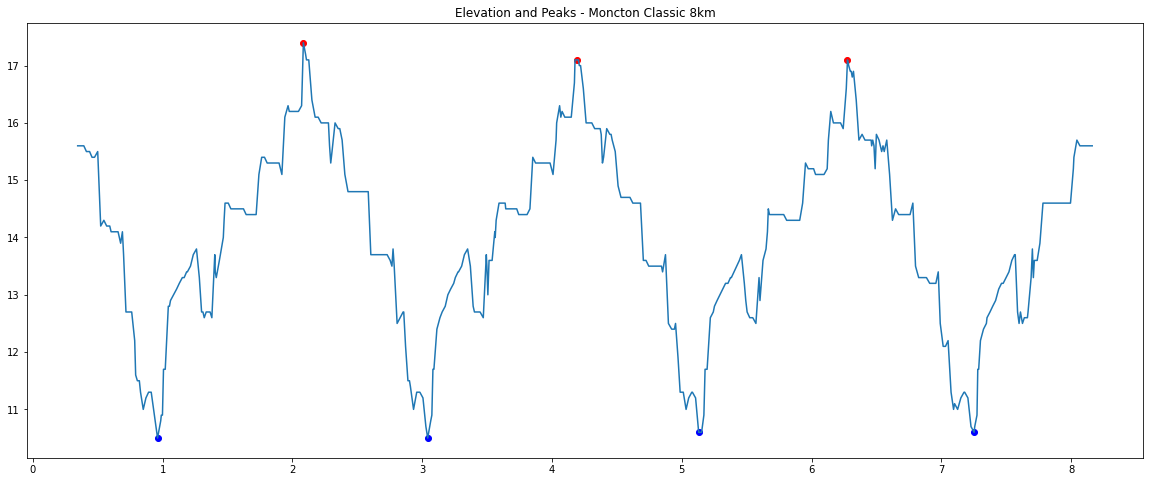

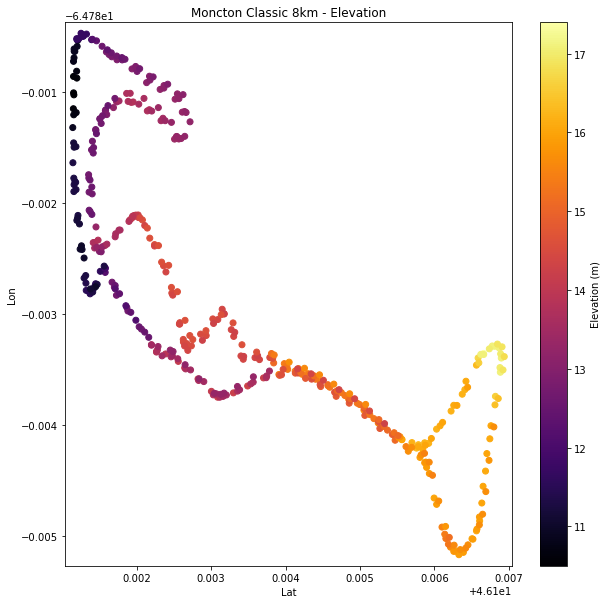

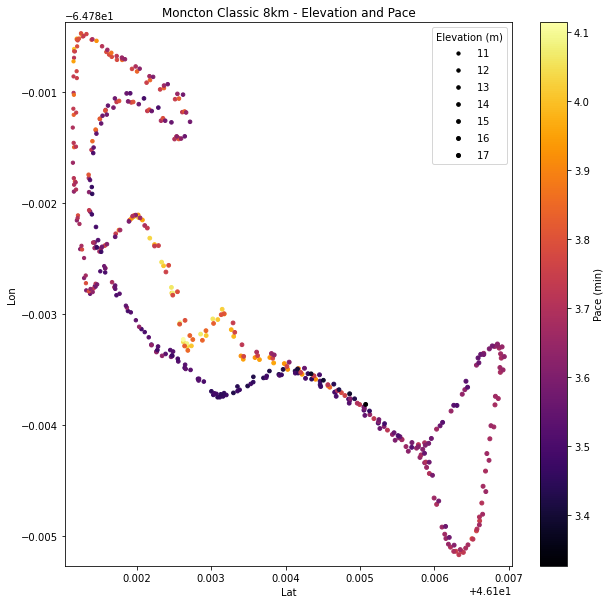

Course average grade adjusted pace - Strava, Minetti
0.9961087018564563 1.0042210508588914
Guelph Arboretum 7_5km.gpx
Total Time :  24  min  13  sec 
Number of hairpins in course
10


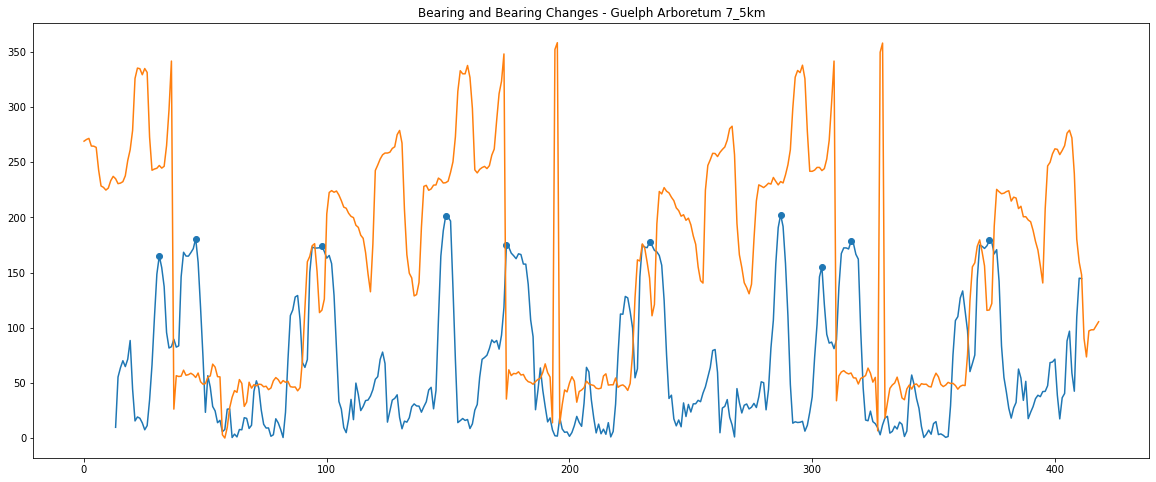

Standard Deviation
58.21782701255018
Total Degrees Turned
26135.731533841994
Race Distance/area of the course are 7500.442 m / -523345.2 m^2
420
396
397


/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


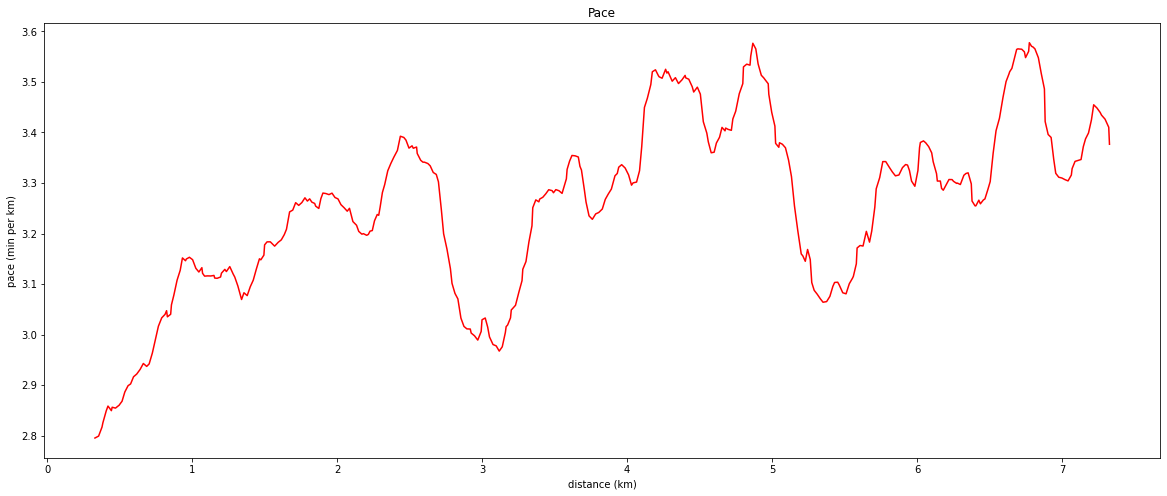

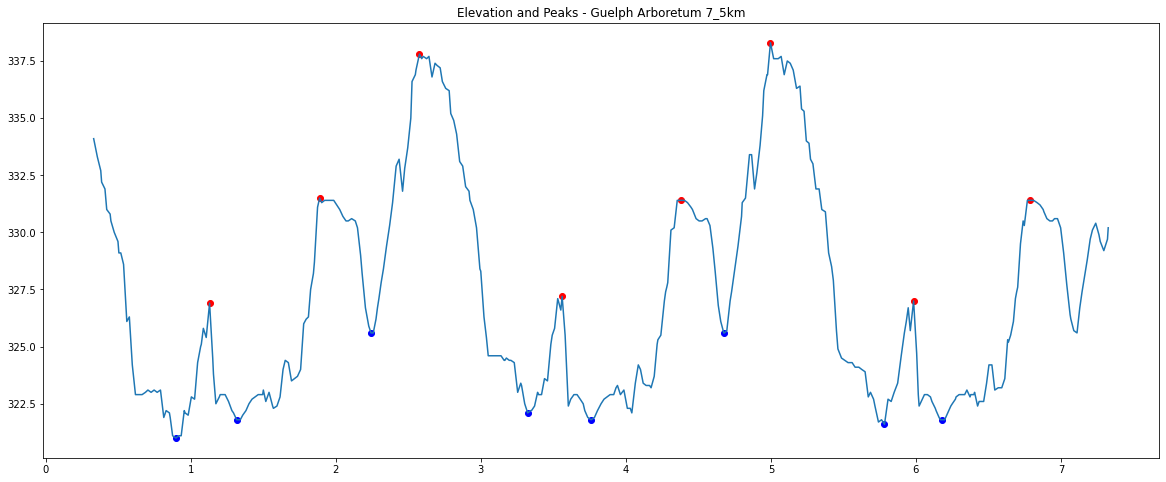

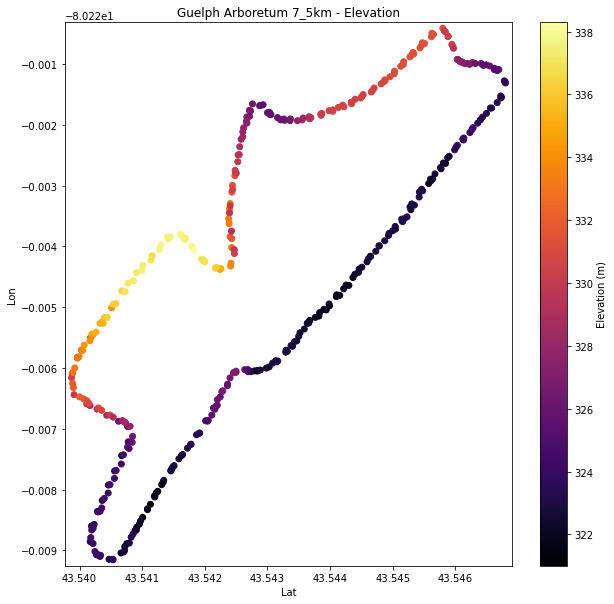

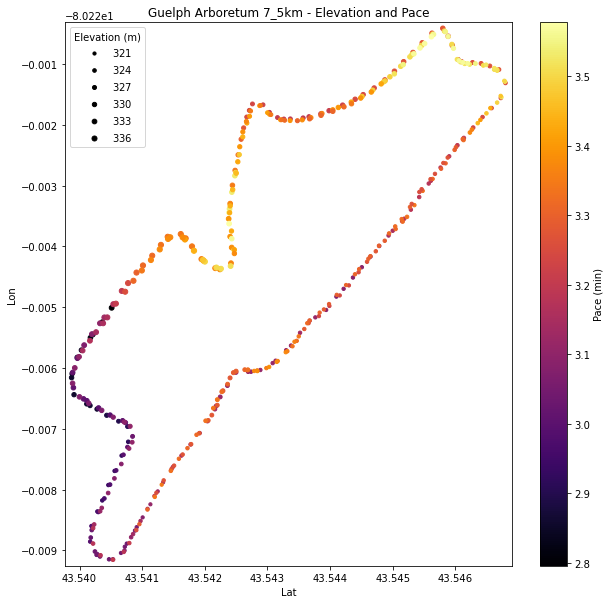

Course average grade adjusted pace - Strava, Minetti
1.0024044597076278 1.0049200072205278
Fanshawe Invitational 8km.gpx
Total Time :  30  min  6  sec 
Number of hairpins in course
6


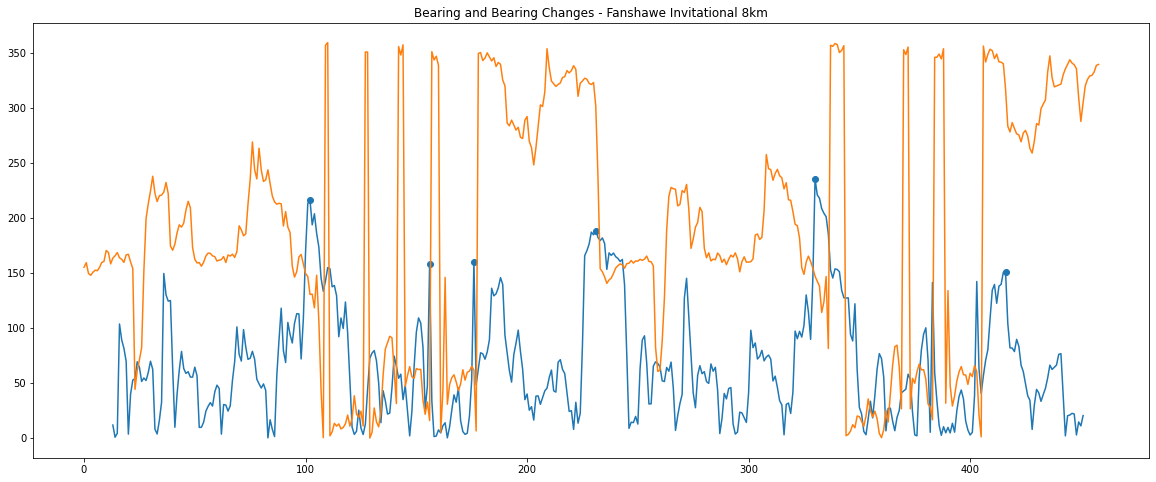

Standard Deviation
51.44944859962321
Total Degrees Turned
29351.570690896126
Race Distance/area of the course are 8126.289 m / 609178.0 m^2
460
436
437


/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


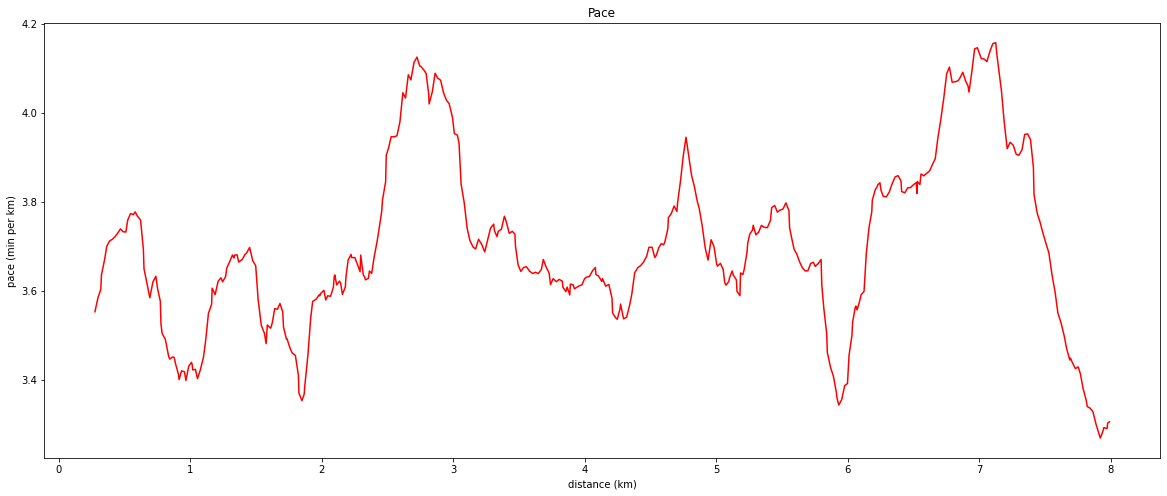

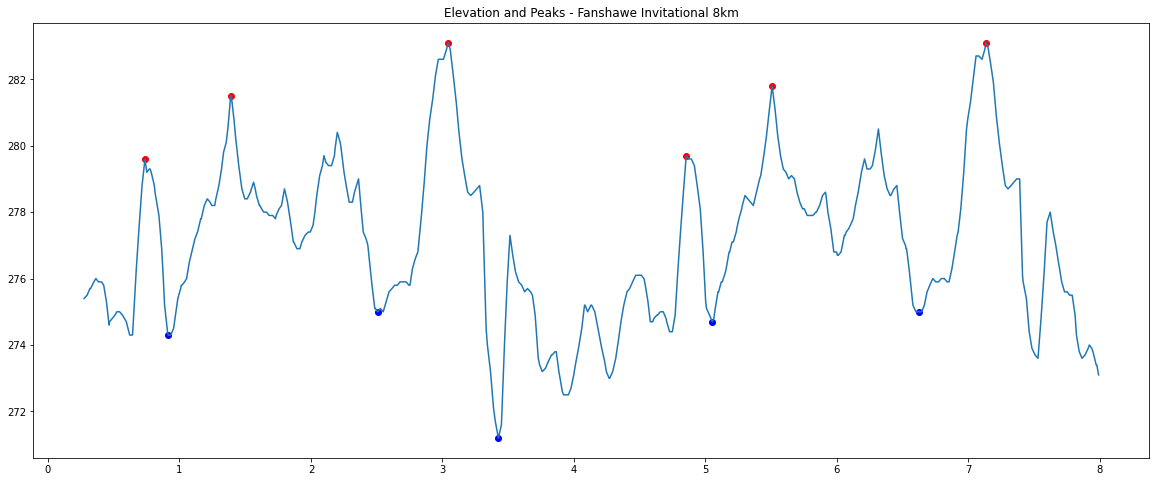

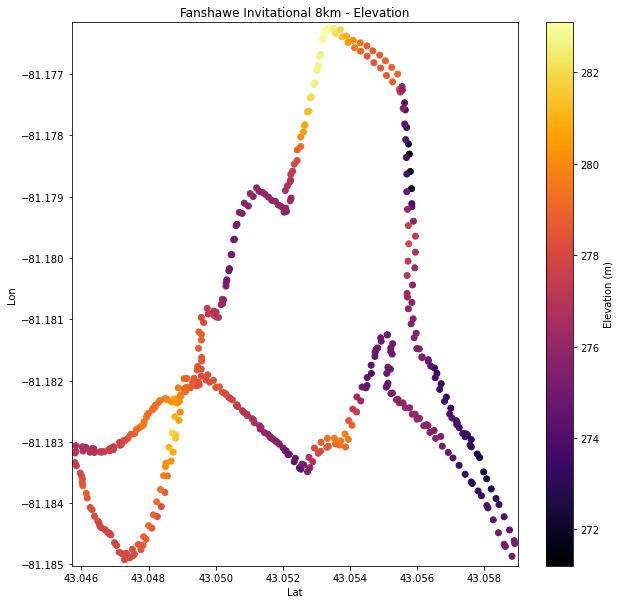

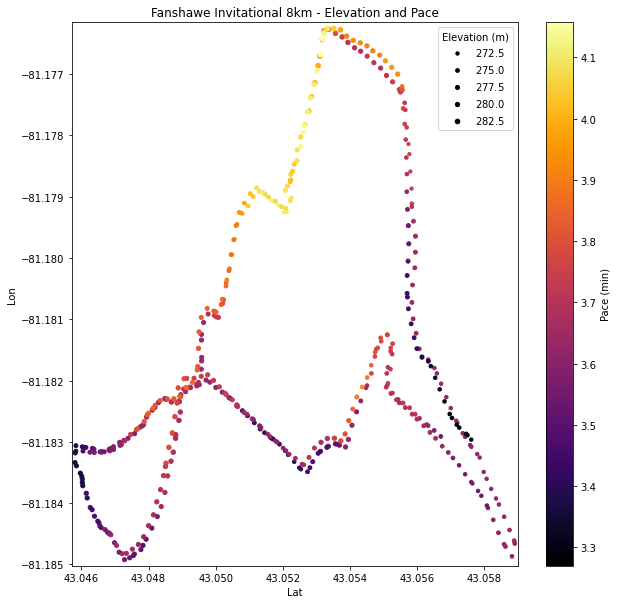

Course average grade adjusted pace - Strava, Minetti
0.9964157591903295 1.001128017087169
StFX Invitational 8km.gpx
Total Time :  29  min  30  sec 
Number of hairpins in course
113


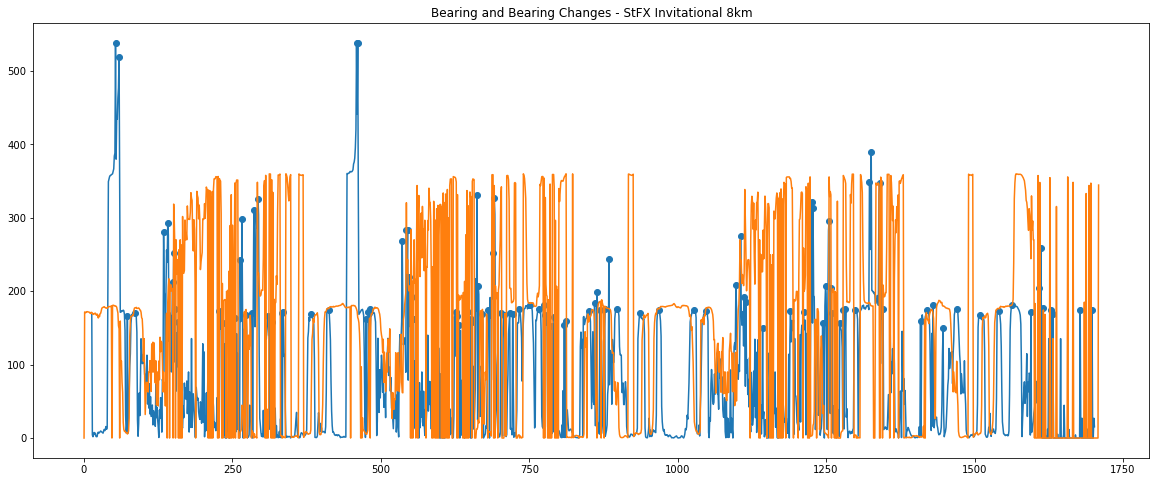

Standard Deviation
89.663793480118
Total Degrees Turned
141355.8497807426
Race Distance/area of the course are 7862.697 m / 209436.0 m^2
1463
1440
1440


/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

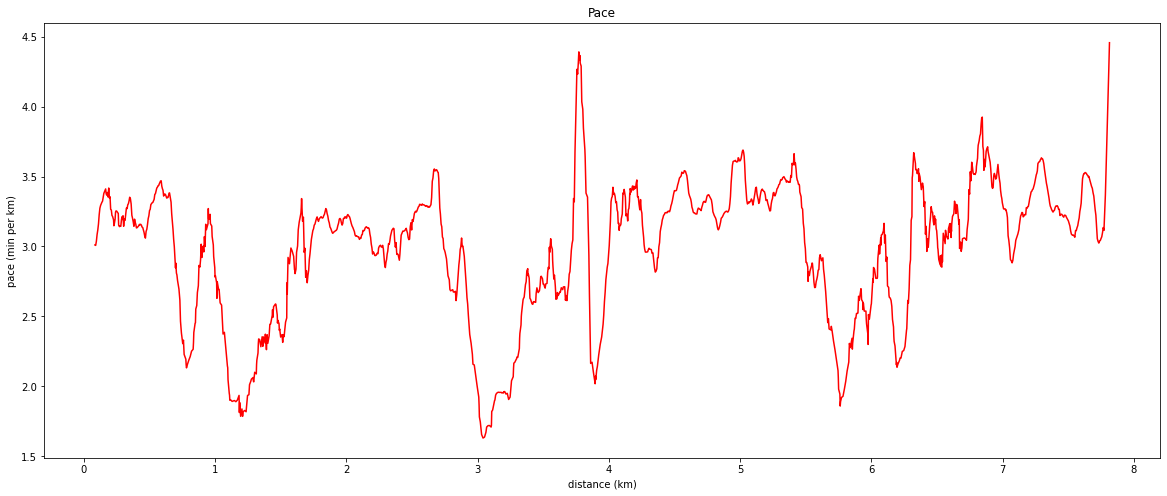

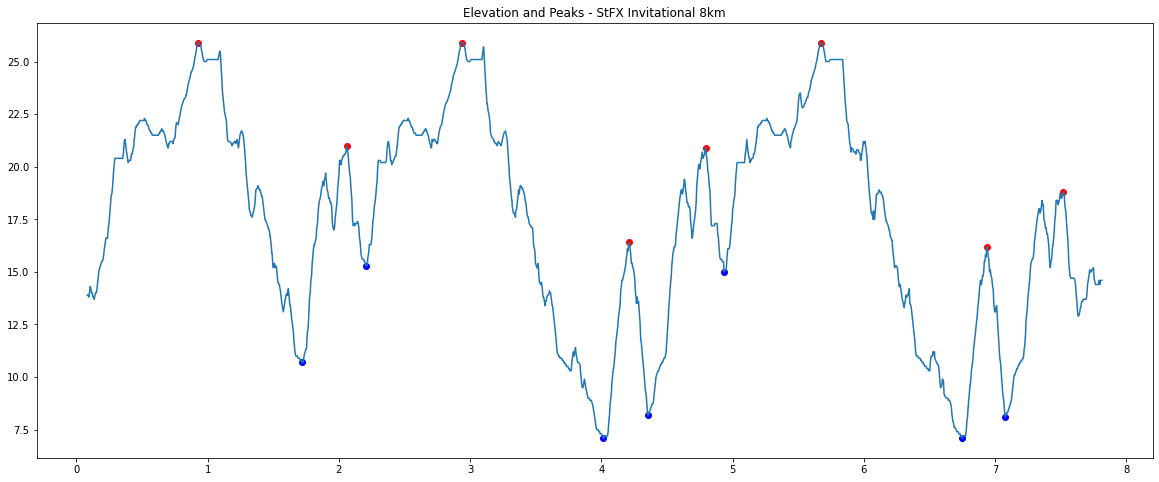

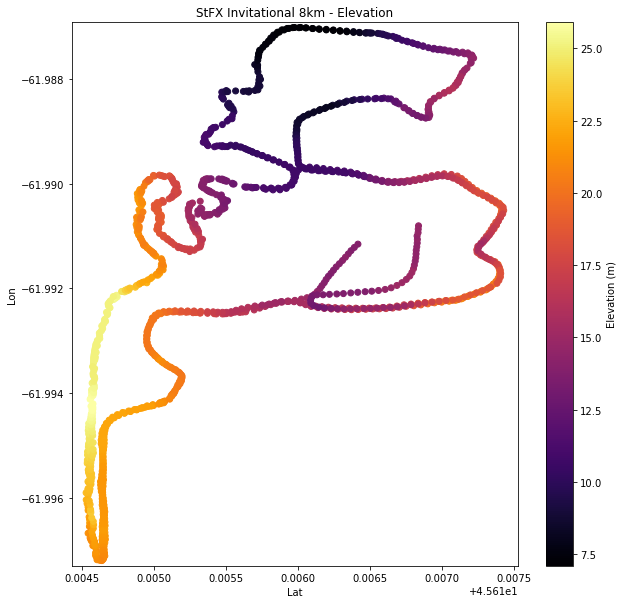

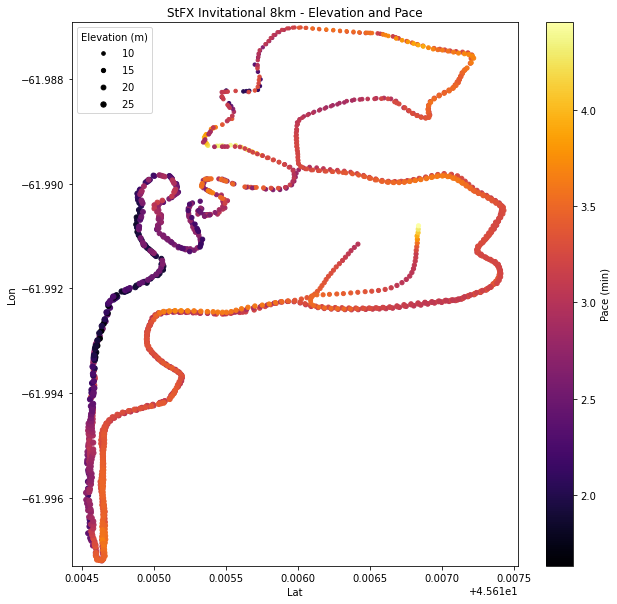

Course average grade adjusted pace - Strava, Minetti
1.017603993903997 1.0198259506208174
Odell Park 7_5km.gpx
Total Time :  29  min  10  sec 
Number of hairpins in course
17


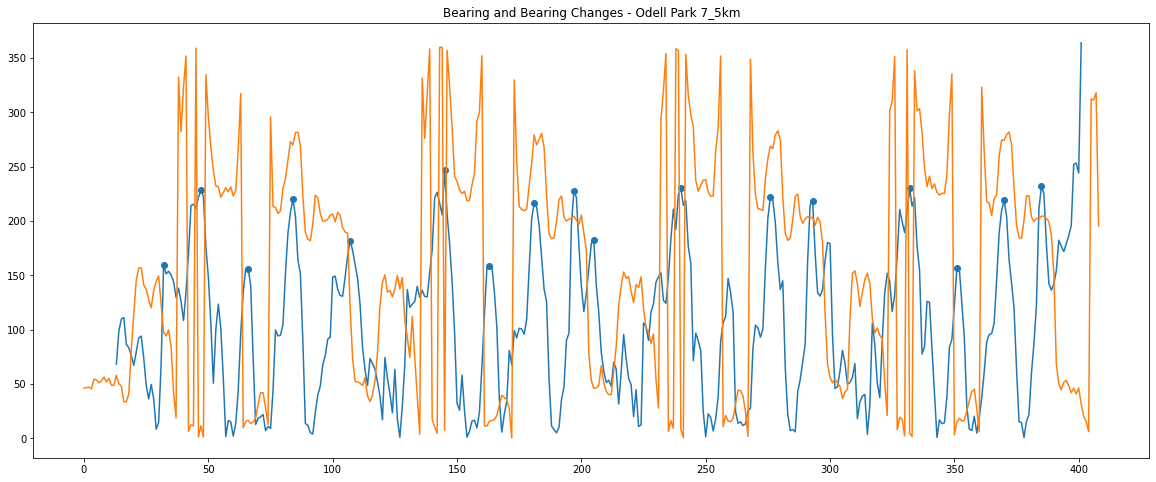

Standard Deviation
68.7401982705644
Total Degrees Turned
40569.43475472915
Race Distance/area of the course are 7984.956 m / -282688.3 m^2
410
386
387


/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


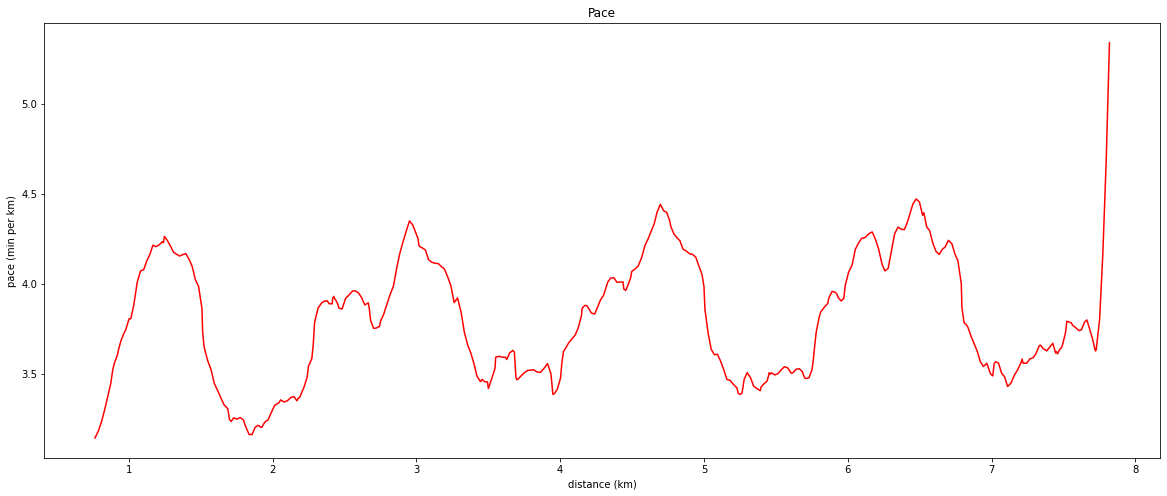

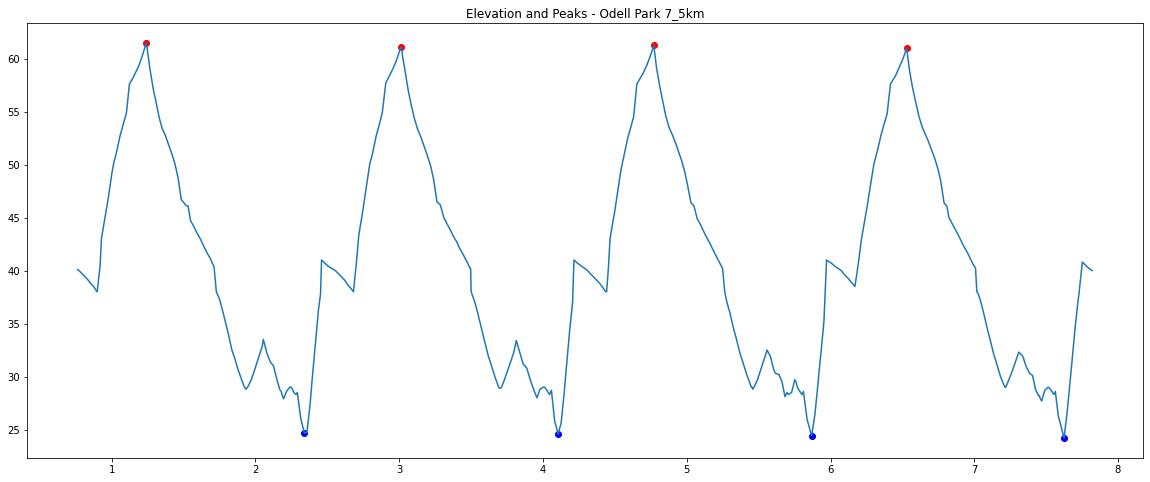

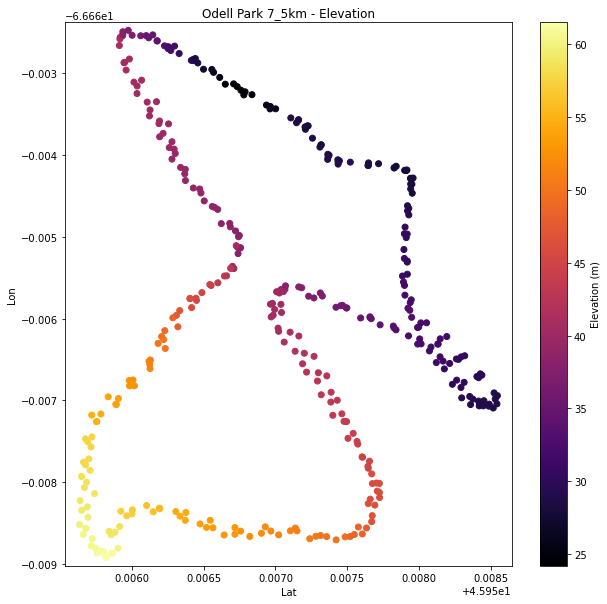

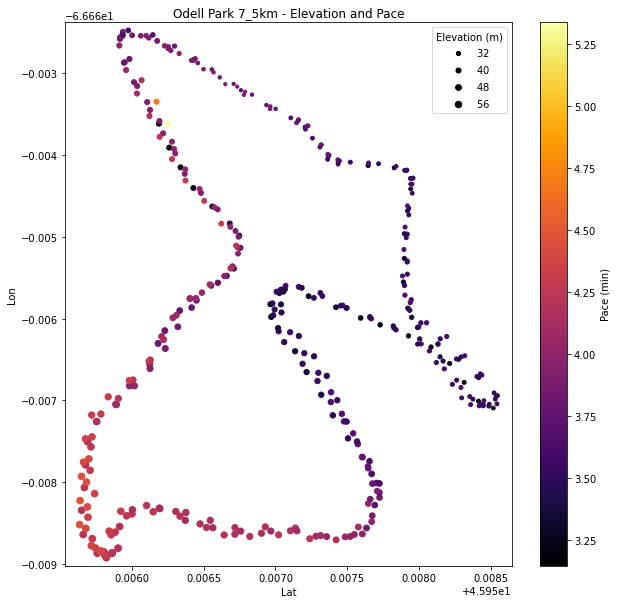

Course average grade adjusted pace - Strava, Minetti
1.045533843621912 1.0405363068924234
Guelph Arboretum 10km.gpx
Total Time :  33  min  27  sec 
Number of hairpins in course
15


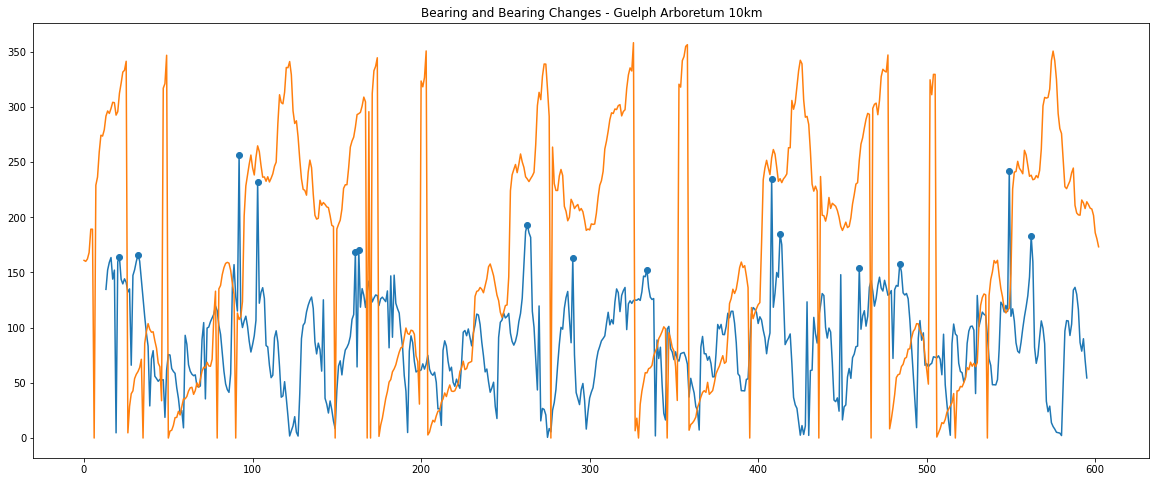

Standard Deviation
42.563387970743754
Total Degrees Turned
50525.53686892566
Race Distance/area of the course are 10088.536 m / -665319.7 m^2
589
566
566


/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

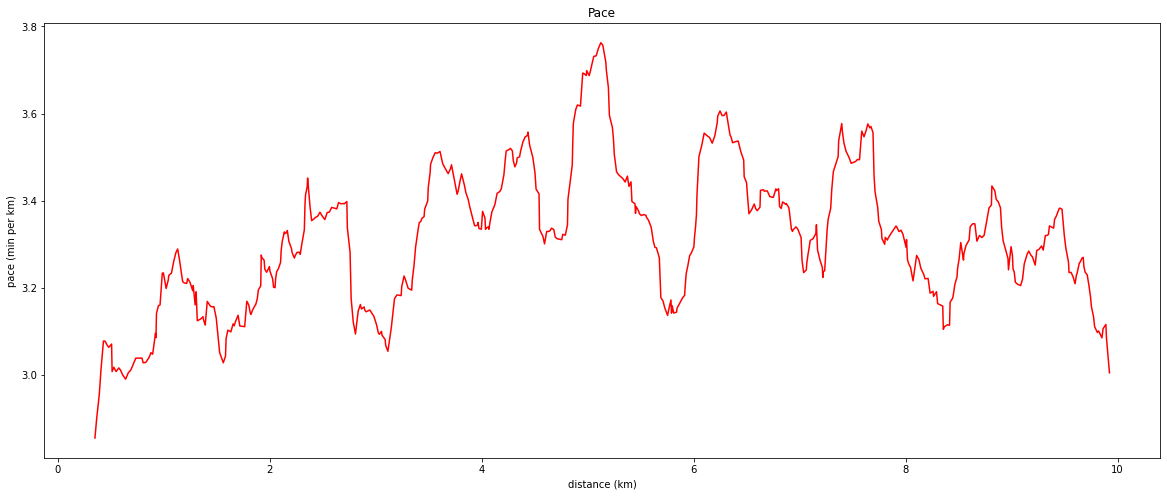

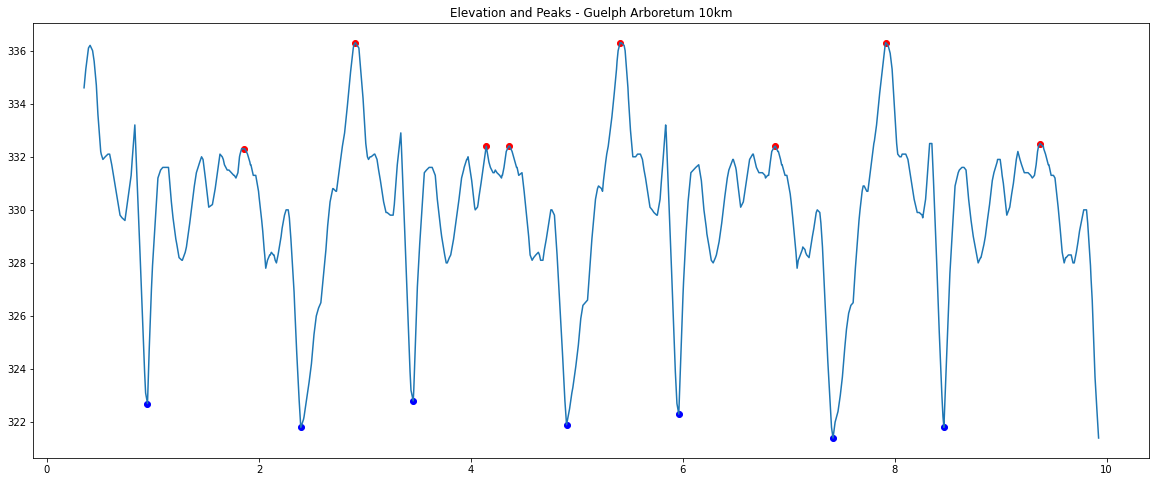

one hill error


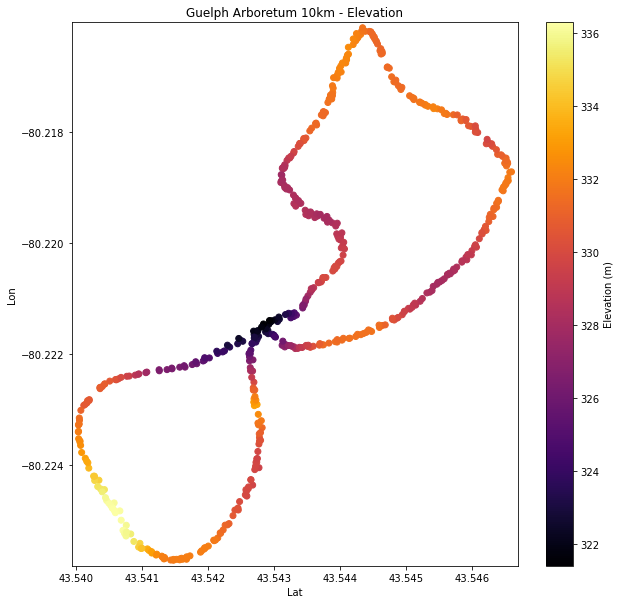

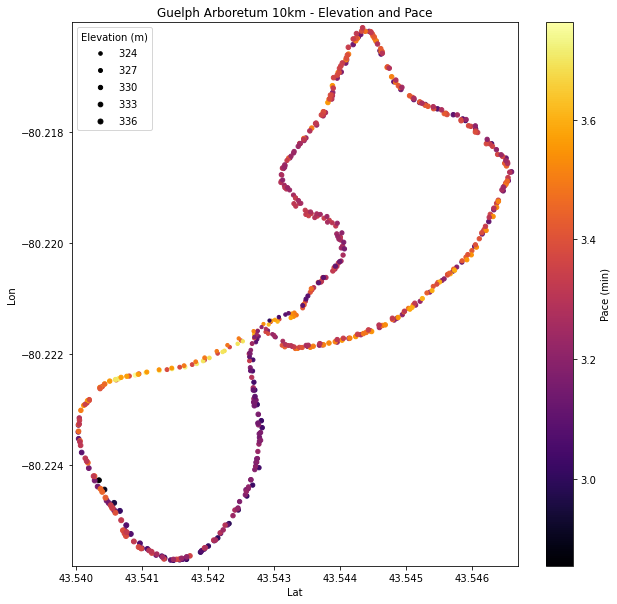

Course average grade adjusted pace - Strava, Minetti
0.9986739138181563 0.9984372666834791
Loyola Lakefront 8km.gpx
Total Time :  26  min  20  sec 
Number of hairpins in course
12


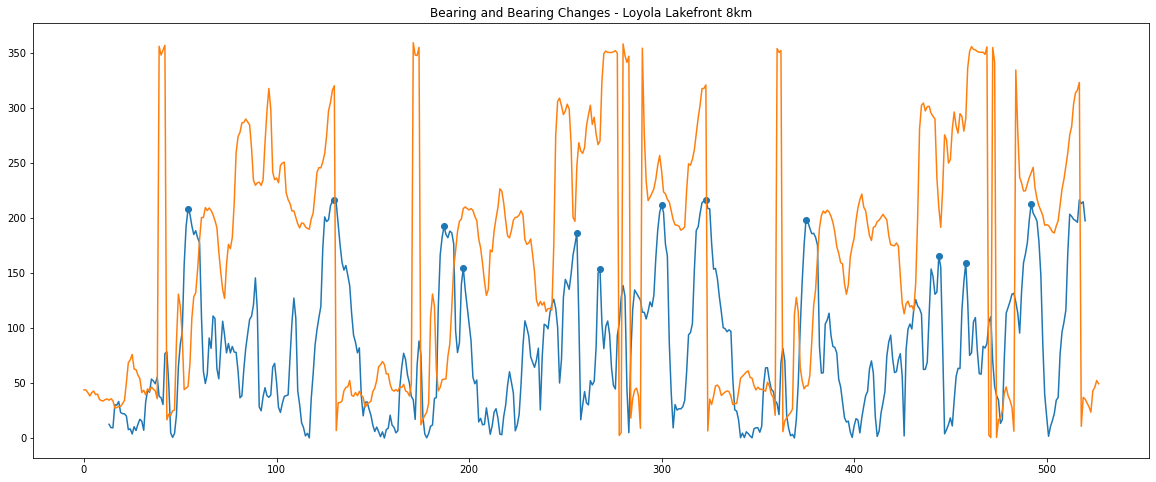

Standard Deviation
61.427559770670456
Total Degrees Turned
41308.175333585146
Race Distance/area of the course are 8107.435 m / 383615.6 m^2
529
505
506


/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


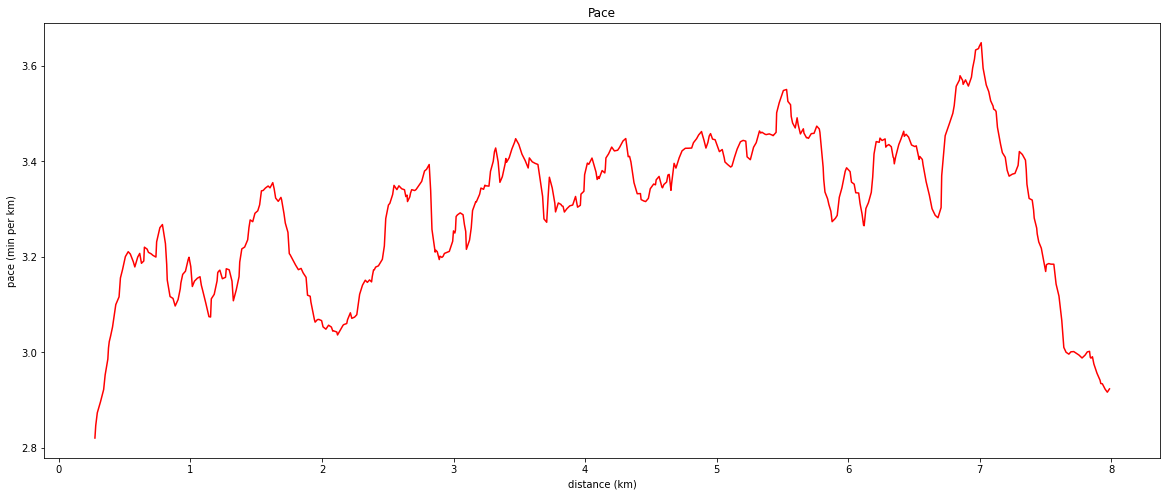

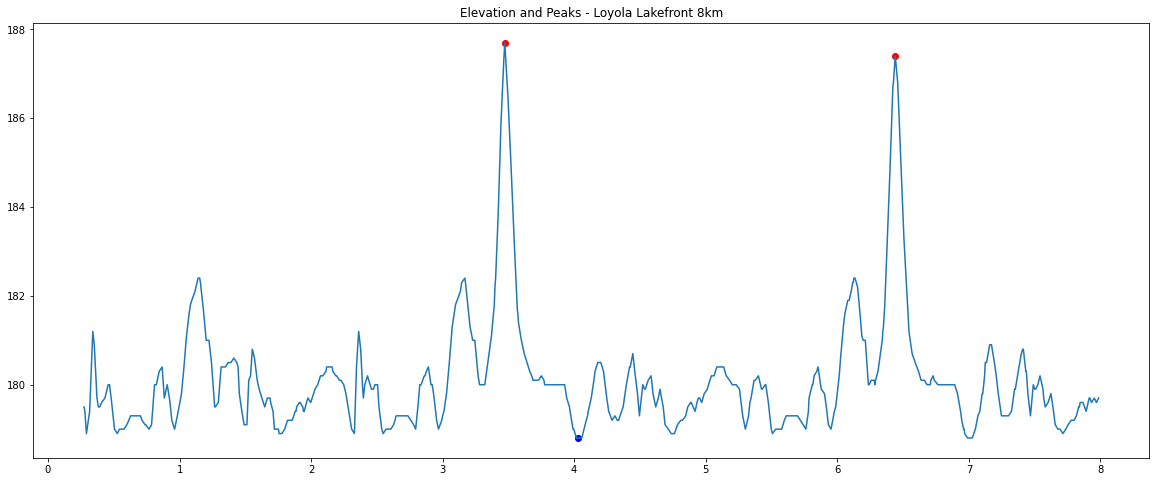

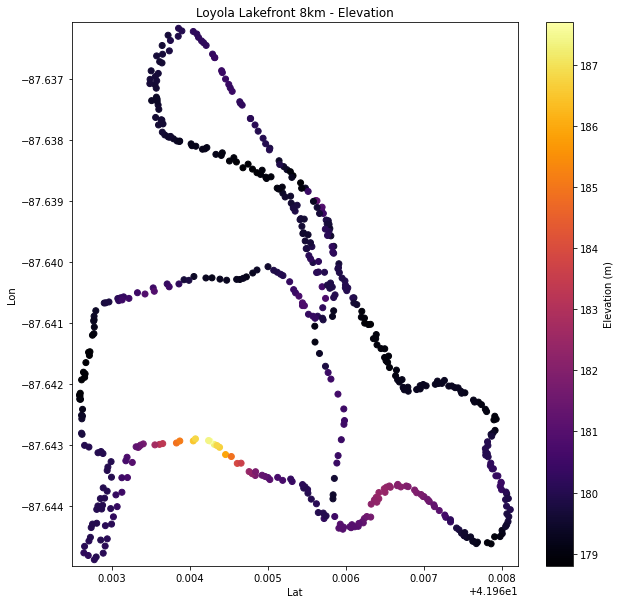

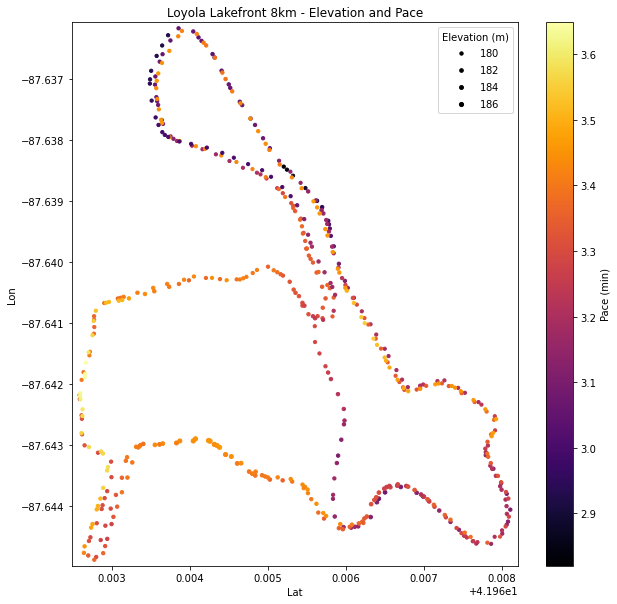

Course average grade adjusted pace - Strava, Minetti
0.9961448886675176 1.0031449945148205
Victoria Park 6km.gpx
Total Time :  21  min  13  sec 
Number of hairpins in course
15


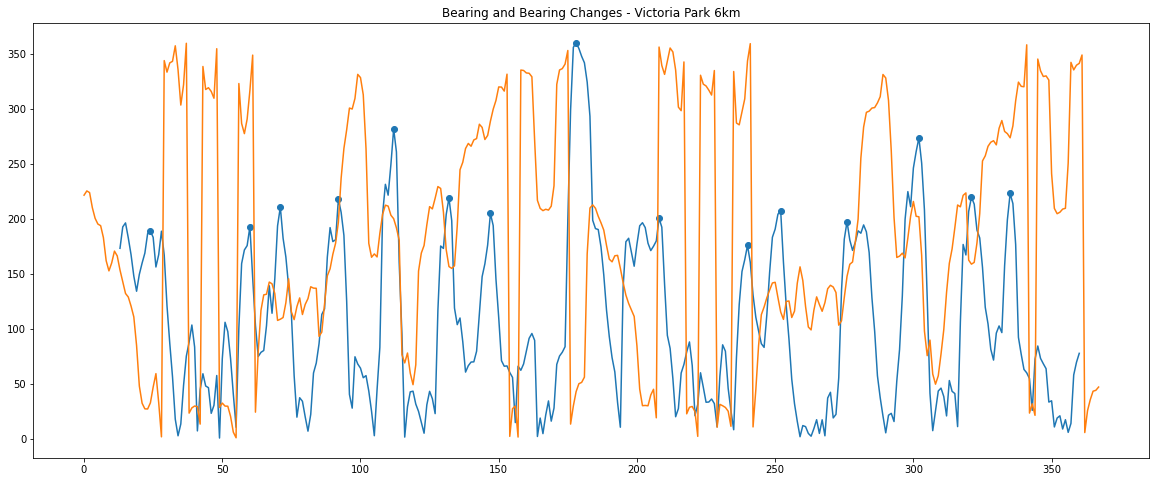

Standard Deviation
77.45717791363943
Total Degrees Turned
37088.06294076306
Race Distance/area of the course are 6025.610 m / 227856.4 m^2
369
345
346


/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


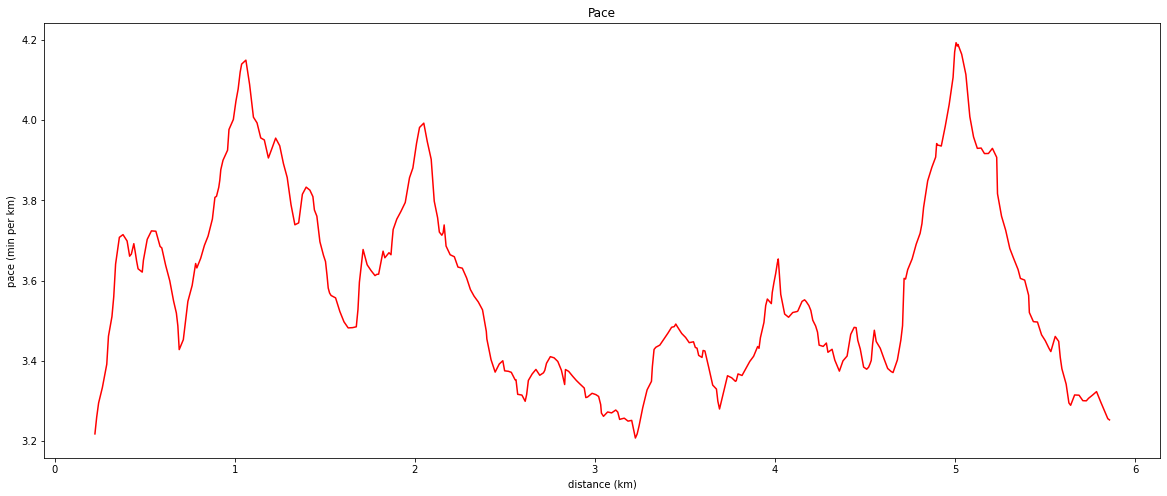

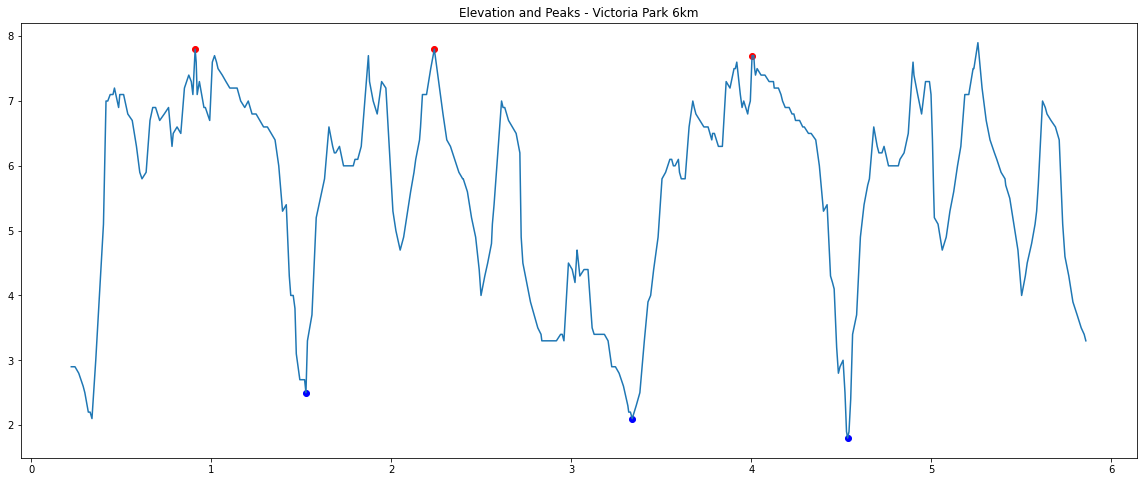

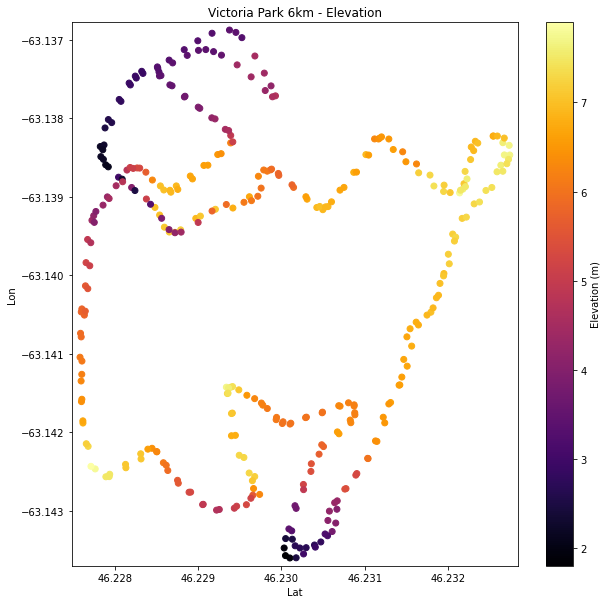

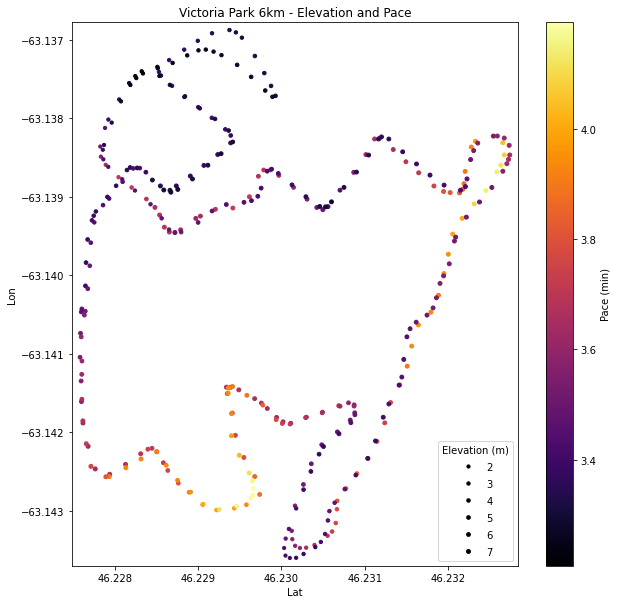

Course average grade adjusted pace - Strava, Minetti
0.993065380826514 0.9963427868596304
Abbotsford 10km.gpx
Total Time :  29  min  19  sec 
Number of hairpins in course
21


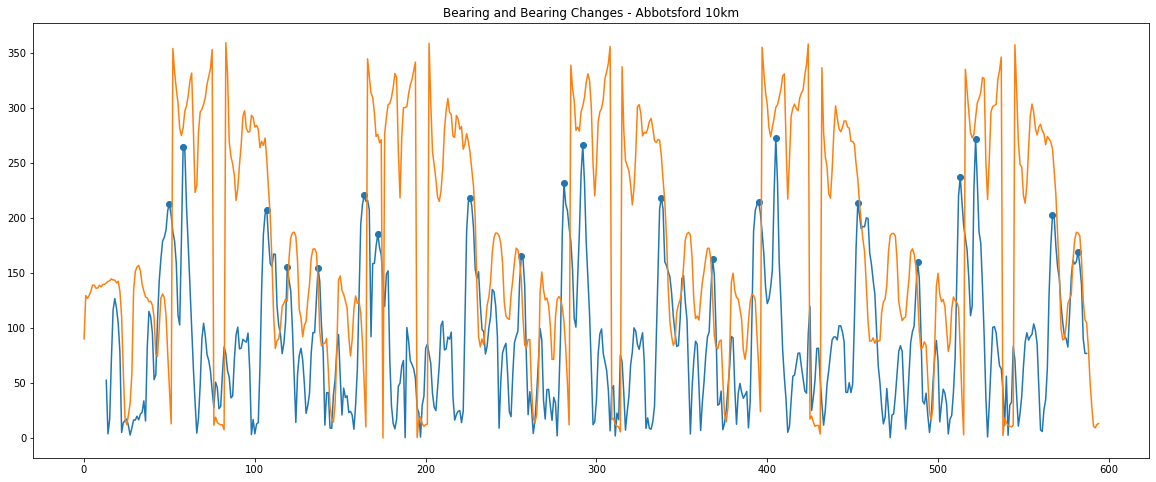

Standard Deviation
62.53126144004536
Total Degrees Turned
50756.70996100019
Race Distance/area of the course are 10007.719 m / 344111.2 m^2
595
571
572


/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

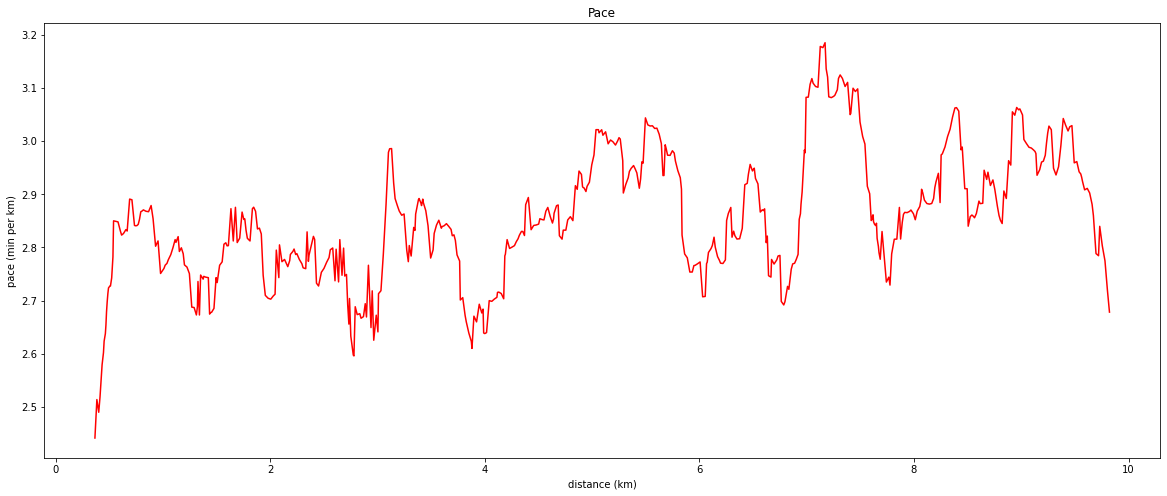

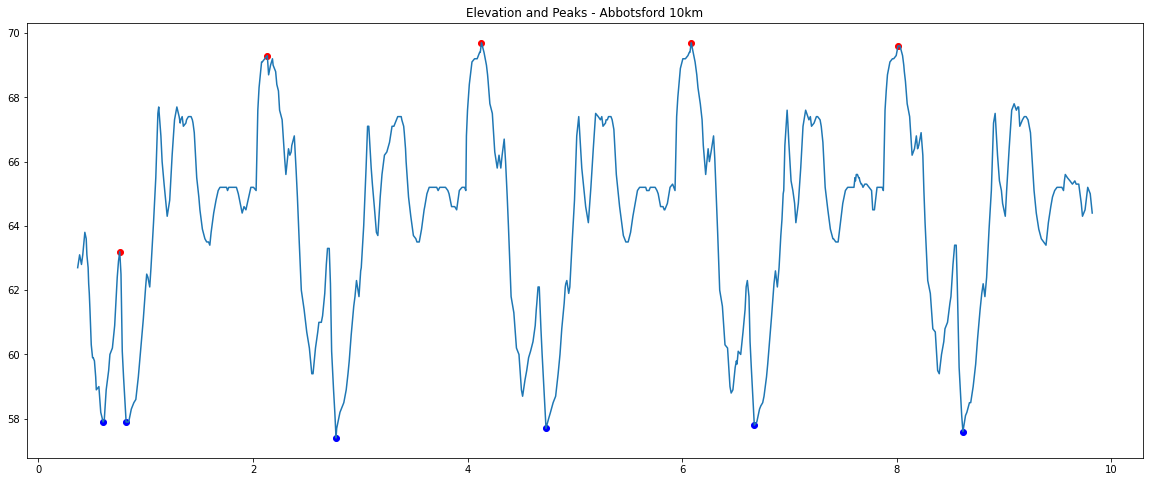

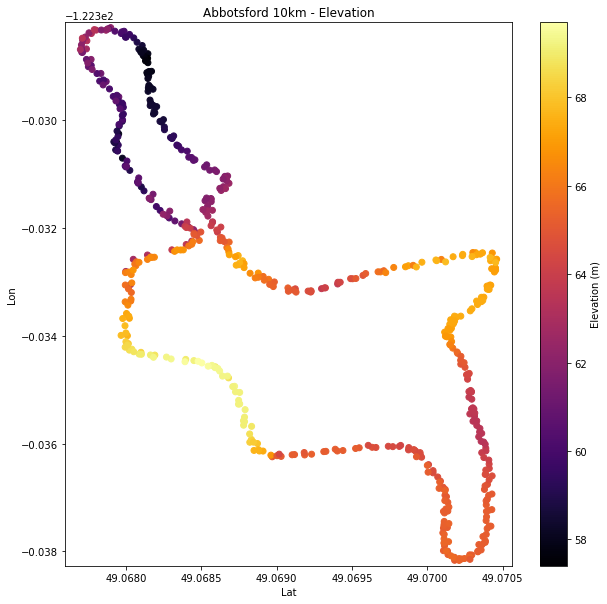

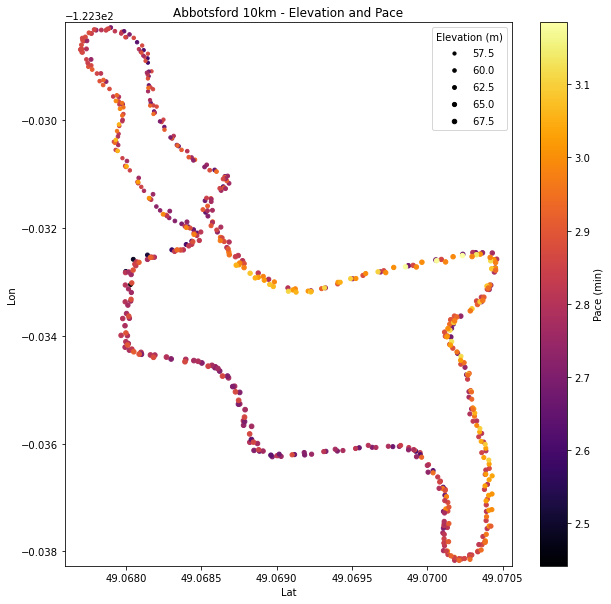

Course average grade adjusted pace - Strava, Minetti
0.9970453962292003 0.9973597301481069
Terre Haute 10km.gpx
Total Time :  0  min  0  sec 
Number of hairpins in course
13


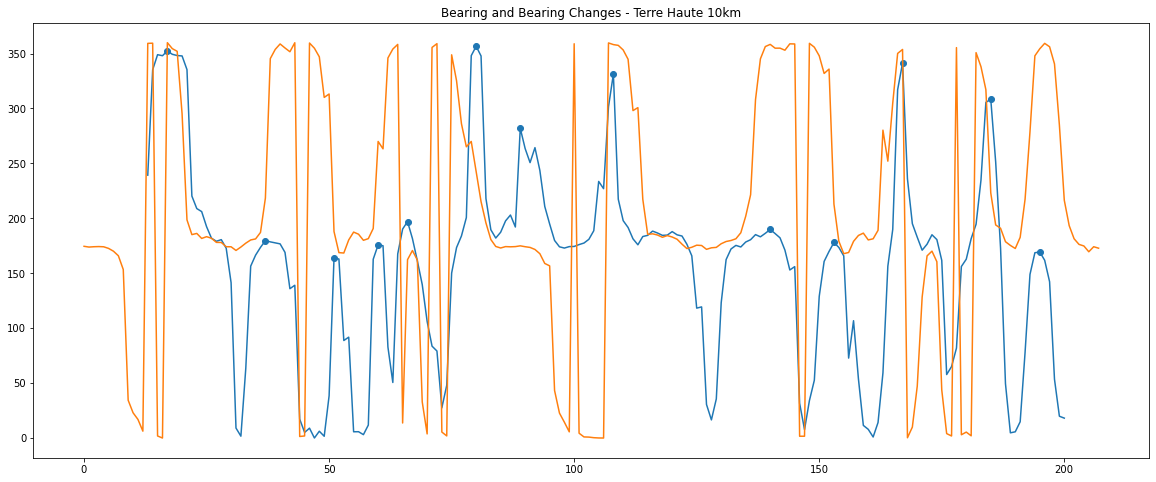

Standard Deviation
88.9264072347215
Total Degrees Turned
29775.11237330812
Race Distance/area of the course are 10307.795 m / -476844.6 m^2
no time


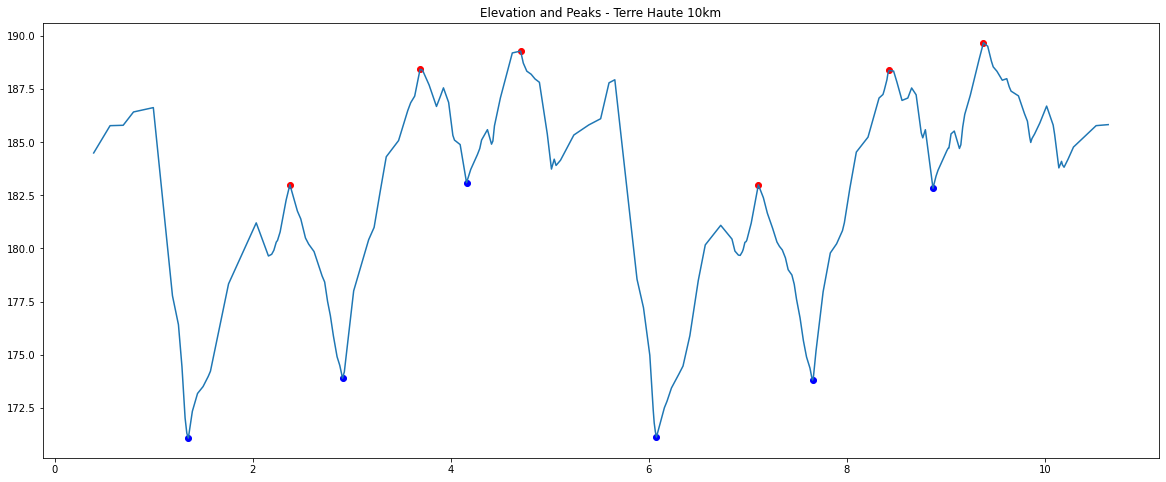

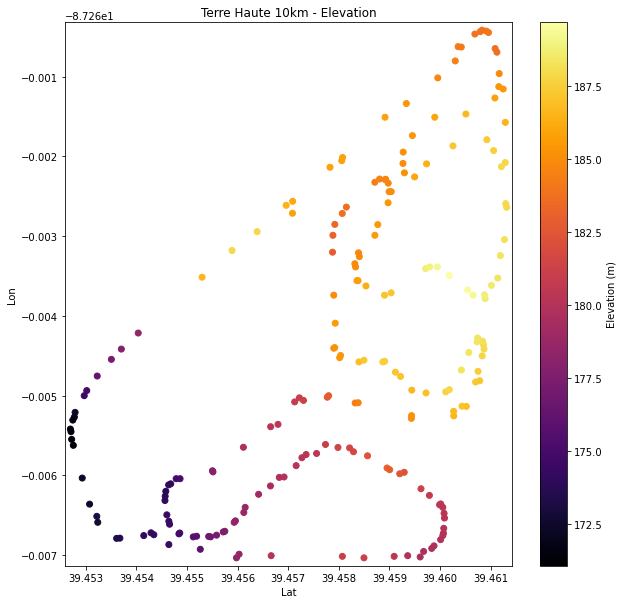

no time
Course average grade adjusted pace - Strava, Minetti
0.9949419318409712 1.00029745928118
Western International 8km.gpx
Total Time :  26  min  44  sec 
Number of hairpins in course
13


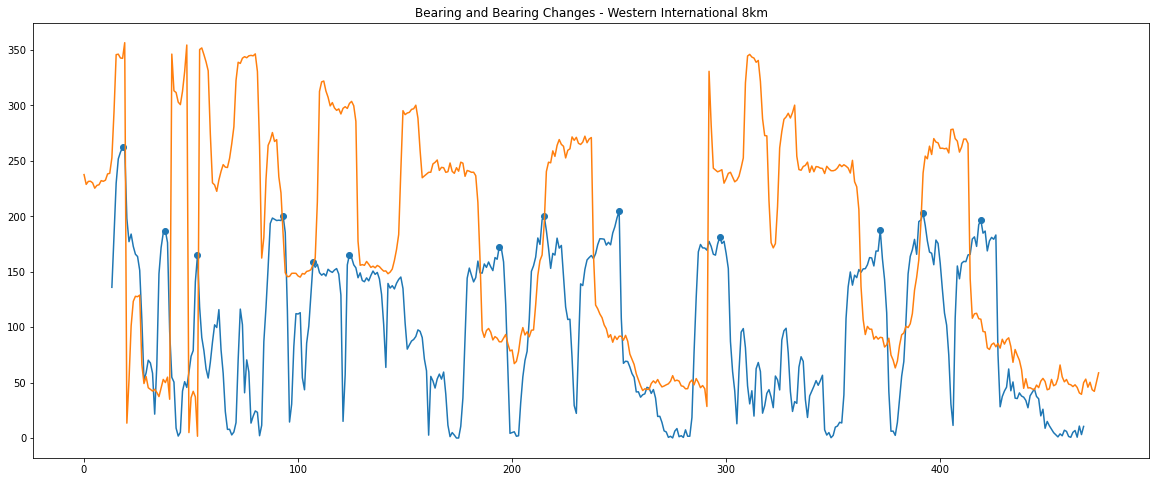

Standard Deviation
66.4216738323642
Total Degrees Turned
44114.12128572632
Race Distance/area of the course are 8000.927 m / 360970.0 m^2
476
452
453


/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


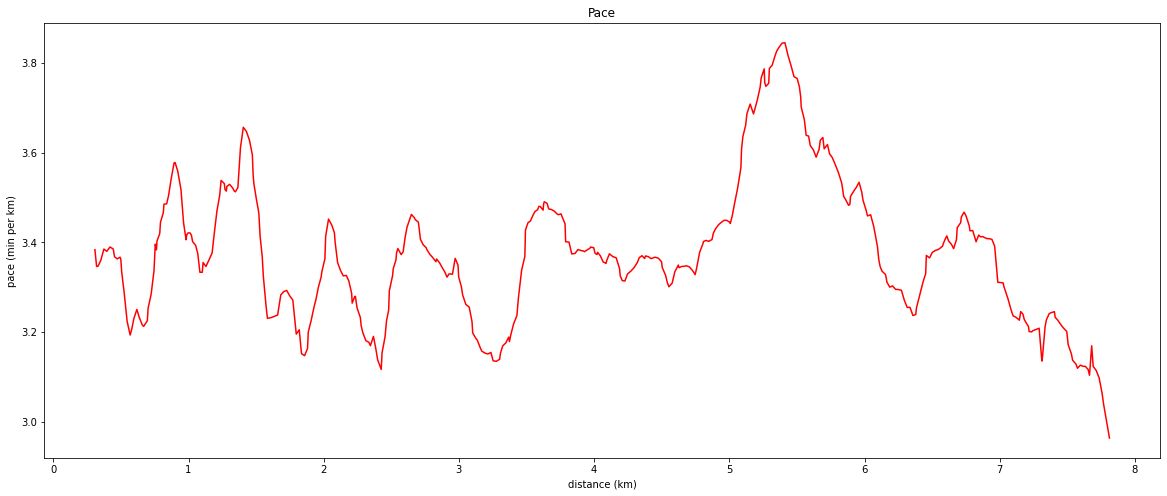

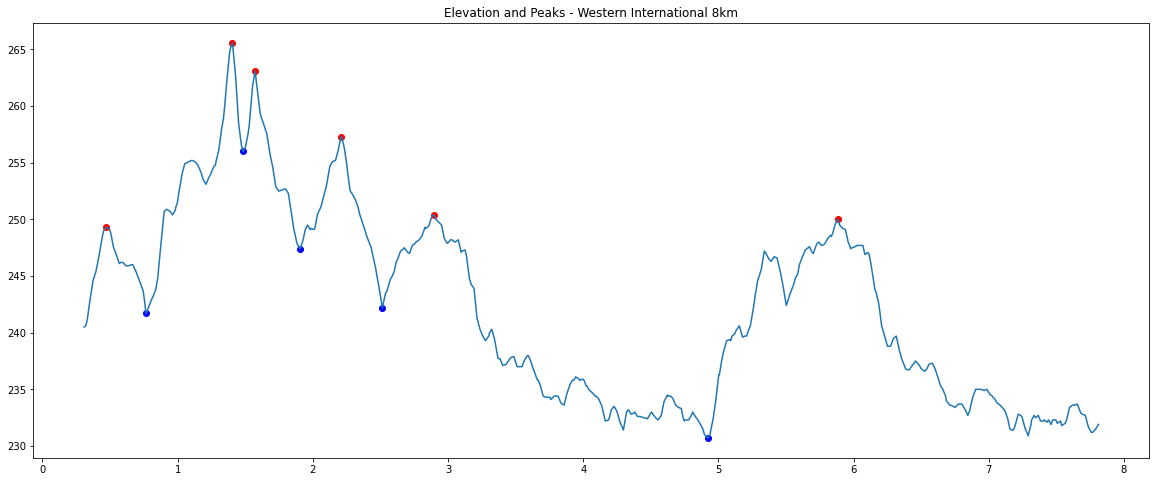

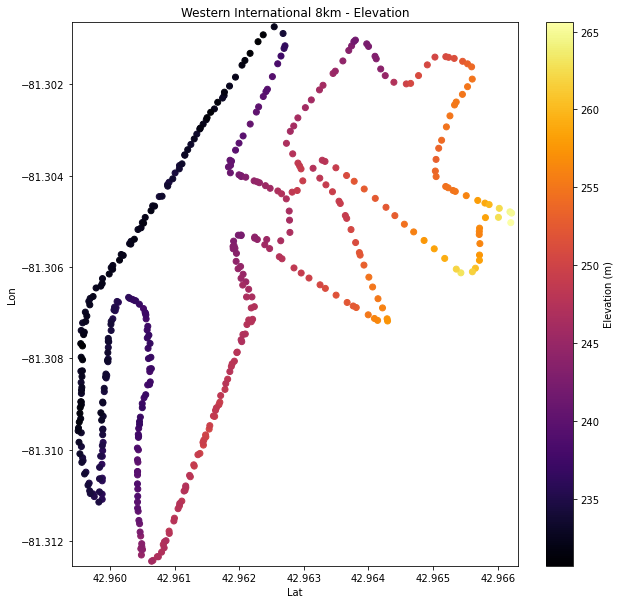

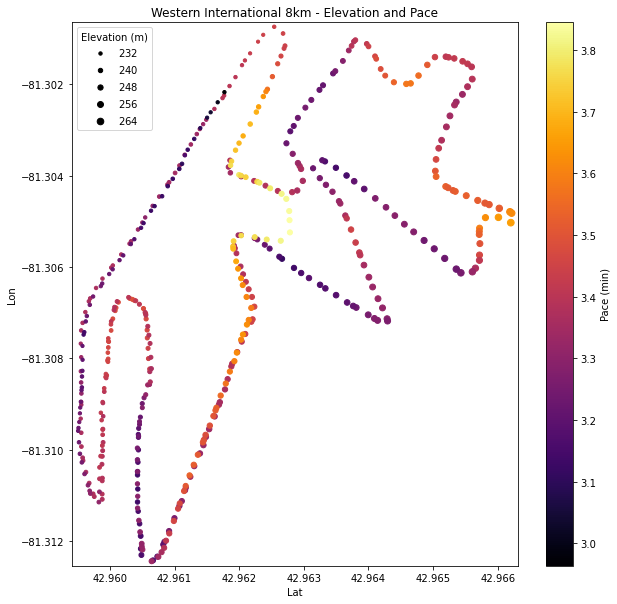

Course average grade adjusted pace - Strava, Minetti
1.0022513671510684 1.0046383239128747
Bayfront Park 7km.gpx
Total Time :  29  min  39  sec 
Number of hairpins in course
38


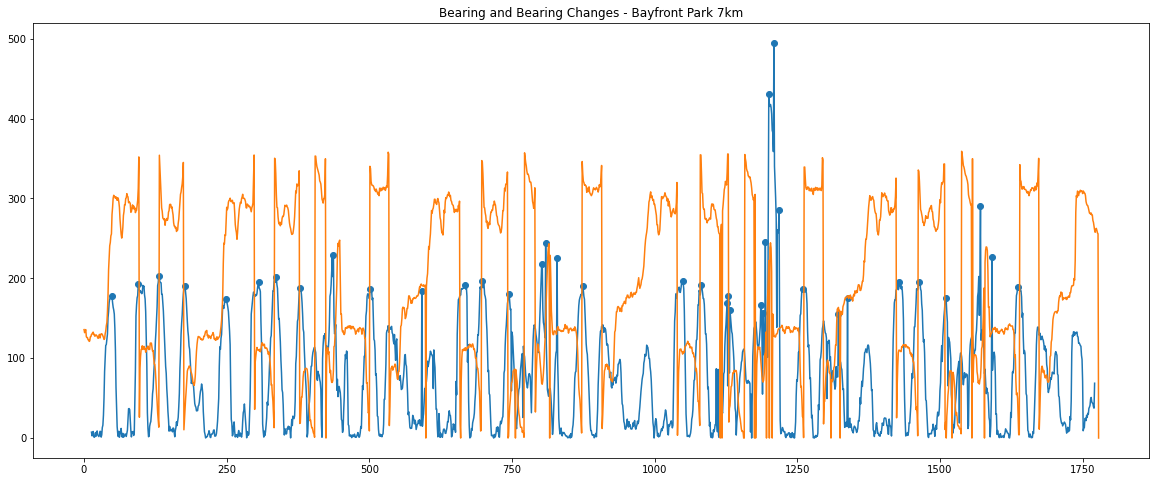

Standard Deviation
69.59235469606118
Total Degrees Turned
138906.27760203308
Race Distance/area of the course are 8304.209 m / -143937.6 m^2
1762
1738
1739


/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

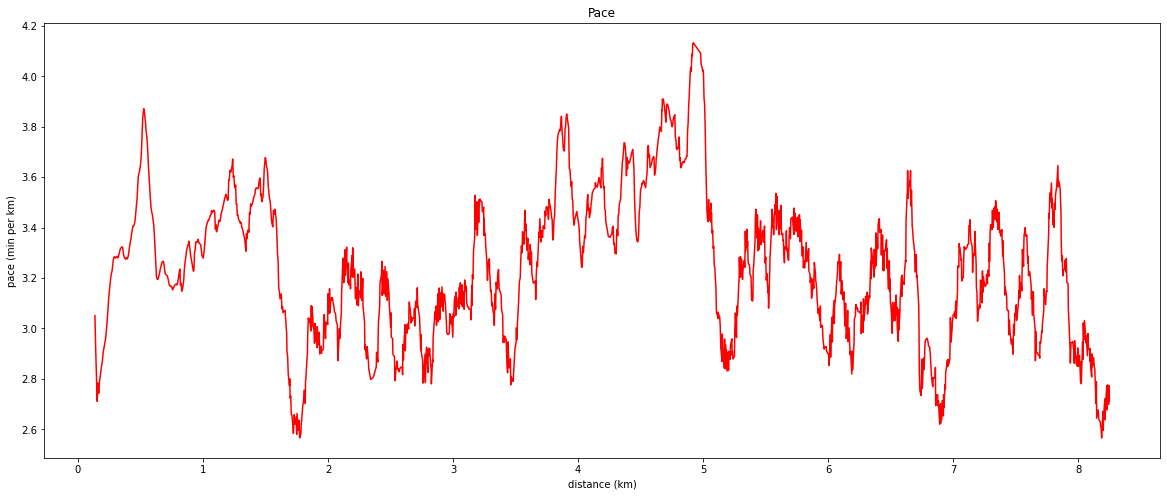

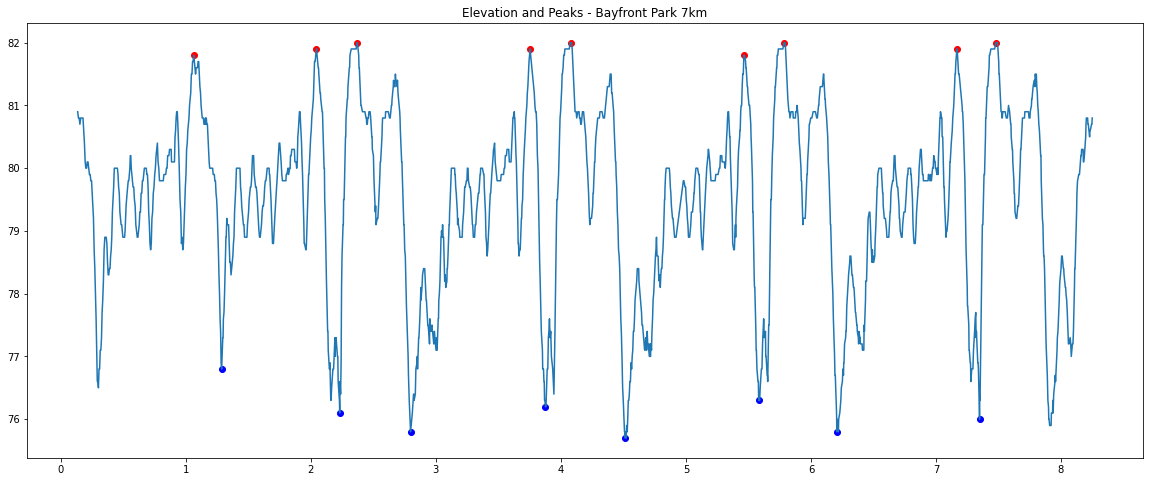

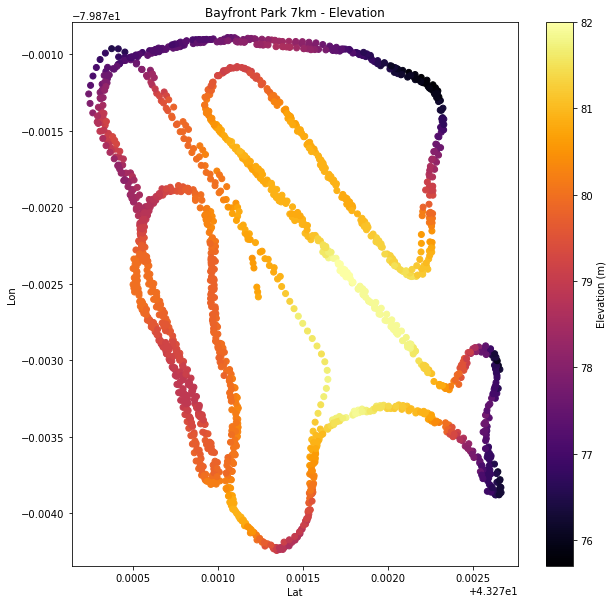

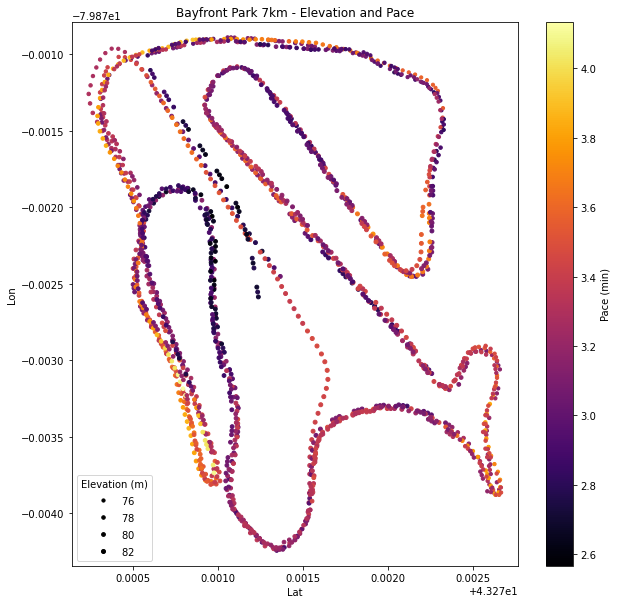

Course average grade adjusted pace - Strava, Minetti
1.008550426439161 1.010421431573942


In [35]:
path = '/Users/jeremywalsh/Documents/Projects/XC/XCCourseAnalysis/Courses/'
directory = os.fsencode(path)
    
courses = []
st_devs = []
tot_deg_turneds = []
perims = []
areas = []
num_hairpins = []
dfs = []
tallest_hills = []
num_hills_list = []
turn_st_devs = []
hill_st_devs = []
tot_elev_gains = []
tot_elev_gain_unfiltereds = []
hill_dfs = []
lengthoftallesthill = []
start_loc_list = []
start_lat_list = []
start_lon_list = []
courseAverageGradeAdjustedPaceStrava_List = []
courseAverageGradeAdjustedPaceMinetti_List = []

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".gpx"): 
        
        print(filename)
        
        base=os.path.basename(path + filename)
        course = os.path.splitext(base)[0]
        courses.append(course)
        
        gpx_file = path + filename
        df = load_run_to_df(gpx_file)
        
        window = 20 #meters long to consider a hairpin turn complete
        df, bearing = angle_diff(df, window)
        
        height = 150 #number of degrees in a hairpin turn over the window length
        turn_st_dev, tot_deg_turned, num_peak = hairpin_detection(df, height, bearing, course)
        
        perim, area = course_area(geod, df)
        
        turn_st_devs.append(turn_st_dev)
        tot_deg_turneds.append(tot_deg_turned)
        perims.append(perim)
        areas.append(area)
        num_hairpins.append(num_peak)
        
        
        df['DistanceChangeInKM'] = df['Distance']-df['Distance'].shift()
        df.set_index('Distance', inplace=True)
#         df = add_alt_time_dif(gpx, df)
        if df['time'].isnull().all() == True:
            print('no time')
        else:
            df = add_pace(df)
        
         
#         course_max_min(df) #plot the course max and min
        
#         #get the hills
#         min_vals, max_vals, hill_climbs, hill_lengths, df = hills(df)
#         print('hills')
#         print(hill_climbs, hill_lengths)
        
        hill_min_height = 5
        length_of_hill = 5
        hill_st_dev, peaks, mins, tot_elev_gain, tot_elev_gain_unfiltered = hills_peaks(df, hill_min_height, length_of_hill, course)
        hill_st_devs.append(hill_st_dev)
        tot_elev_gains.append(tot_elev_gain)
        tot_elev_gain_unfiltereds.append(tot_elev_gain_unfiltered)
        
        min_vals, max_vals, hill_climbs, hill_lengths = hill_details(df, peaks, mins)
        hill_grade = np.divide(hill_climbs, hill_lengths)*100
        # put all of the hill details into a dataframe of some sort so that we can compare the different sites
        hill_df = pd.DataFrame({'Hill Height': hill_climbs, 'Hill Distance': hill_lengths, 'Hill Grade': hill_grade})
        #drop hills with too low of a grade
        hill_df.drop(hill_df[hill_df['Hill Grade'] < 1].index, inplace=True)
        hill_df.reset_index(drop=True, inplace=True)
        num_hills = len(hill_df)
        
        #list of tallest hill for each course
        tallest_hills.append(hill_df['Hill Height'].max())
        if len(hill_df)>0: #check if there are any hills
            lengthoftallesthill.append(hill_df[hill_df['Hill Height']==max(hill_df['Hill Height'])]['Hill Distance'].min())
        else:
            lengthoftallesthill.append(np.nan)
        hill_dfs.append(hill_df)
        num_hills_list.append(num_hills)
        start_lat_list.append(df['Lat'].iloc[0])
        start_lon_list.append(df['Lon'].iloc[0])
        
        #Add in more columns
#         df = add_accuDist(df)
#         df = add_pace(df)
        # Couple plots
        elev_map(course, df)
        
        if df['time'].isnull().all() == True:
            print('no time')
        else:
            pace_elev_map(course, df)
            
        #try Grade Adjusted Pace
        import GradeAdjustedPace
        GAP = GradeAdjustedPace.GAP(df)
        courseAverageGradeAdjustedPaceStrava = GAP.getStravaCourseGAP()
        courseAverageGradeAdjustedPaceMinetti = GAP.getMinettiCourseGAP()
        print('Course average grade adjusted pace - Strava, Minetti')
        print(courseAverageGradeAdjustedPaceStrava, courseAverageGradeAdjustedPaceMinetti)
        courseAverageGradeAdjustedPaceStrava_List.append(courseAverageGradeAdjustedPaceStrava)
        courseAverageGradeAdjustedPaceMinetti_List.append(courseAverageGradeAdjustedPaceMinetti)
        
        dfs.append(df)
        
course_info_df = pd.DataFrame({'Course': courses, 'Turn Stdev': turn_st_devs, 
                               'Total Degrees Turned': tot_deg_turneds, 'Perimeters/Total Distance': perims,
                              'Course Area (m^2)': areas, 'Number of Hairpin Turns': num_hairpins, 'Hill Stdev': hill_st_devs,
                              'Tallest Hill (m)': tallest_hills, 'Length of tallest hill (m)': lengthoftallesthill, 'Number of Hills': num_hills_list,
                              'Total Elevation Gain (m)': tot_elev_gains, 'Total Elevation Gain Unfiltered (m)': tot_elev_gain_unfiltereds,
                              'Start Lat': start_lat_list, 'Start Lon': start_lon_list, 'Course Ave. GAP - Strava': courseAverageGradeAdjustedPaceStrava_List,
                              'Course Ave. GAP - Minetti': courseAverageGradeAdjustedPaceMinetti_List})
course_info_df['Course Area (m^2)'] = course_info_df['Course Area (m^2)'].abs() #sometiems area is negative


In [37]:
course_info_df.sort_values(by=['Total Elevation Gain (m)'], ascending=False)

Course  Turn Stdev  Total Degrees Turned  \
10            Odell Park 7_5km   68.740198          40569.434755   
1   Western International 10km   62.718635          58241.752843   
0               King City 10km   48.730365          42051.013427   
11       Guelph Arboretum 10km   42.563388          50525.536869   
4          Point Pleasant Park   65.566509          71603.024628   
14             Abbotsford 10km   62.531261          50756.709961   
16   Western International 8km   66.421674          44114.121286   
7       Guelph Arboretum 7_5km   58.217827          26135.731534   
5             Malden Park 10km   66.549189          39089.098536   
9        StFX Invitational 8km   89.663793         141355.849781   
15            Terre Haute 10km   88.926407          29775.112373   
8    Fanshawe Invitational 8km   51.449449          29351.570691   
3              Fort Henry 10km   66.866820          62355.746635   
17           Bayfront Park 7km   69.592355         138906.277602   
12        Loyola Lakefront 8km   61.427560          41308.175334   
2       Louisville Classic 8km   51.234135          36288.409822   
6          Moncton Classic 8km   83.696741          45938.703747   
13           Victoria Park 6km   77.457178          37088.062941   

    Perimeters/Total Distance  Course Area (m^2)  Number of Hairpin Turns  \
10                7984.955851      282688.257068                       17   
1                 9968.833143      460036.173499                       18   
0                10038.907997      950170.390341                        9   
11               10088.535560      665319.677772                       15   
4                 9724.775310      228902.224241                       26   
14               10007.719497      344111.183926                       21   
16                8000.926866      360970.044217                       13   
7                 7500.441631      523345.157986                       10   
5                 9634.529662      651923.814169                       20   
9                 7862.697327      209436.040107                      113   
15               10307.794825      476844.612398                       13   
8                 8126.288553      609178.006826                        6   
3                10110.727004      324374.359032                       21   
17                8304.208521      143937.636110                       38   
12                8107.435288      383615.593944                       12   
2                 8540.026287      643863.731242                        5   
6                 8300.695758      112459.945592                       12   
13                6025.609582      227856.418118                       15   

    Hill Stdev  Tallest Hill (m)  Length of tallest hill (m)  Number of Hills  \
10   10.270125             36.70                    0.664571                4   
1     8.672511             27.20                    0.638544                9   
0     6.293955             31.70                    0.903276                7   
11    2.952445             14.50                    0.514402                3   
4     8.170923             17.20                    0.445803                8   
14    3.066162             12.30                    1.355669                5   
16    8.348896             23.90                    0.638648                6   
7     4.663654             12.70                    0.322007                8   
5     3.767340              6.10                    0.242550                1   
9     4.892741             12.70                    0.443480                8   
15    4.972641             14.58                    0.772321                6   
8     2.377986              8.50                    1.428763                6   
3     1.600561              9.20                    1.287430                3   
17    1.483024              6.10                    0.956048                9   
12    1.277731              8.60                    

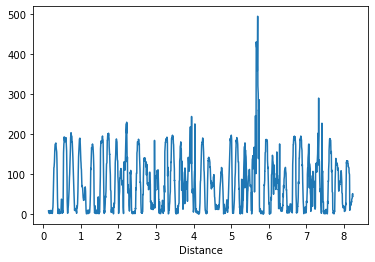

In [39]:
df['angle_diff'].plot()

# fix angle diff or hairpin detection. Maybe interpolate since that makes it easier. Once it works well alongside hairpin detection, then remove all instances of gpx_interp (sp?) and copy to main